In [1]:
from glob import glob
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import sys
sys.path.append('../')
from source_names_dict import source_names_readable, source_distances_mpc, get_simbad_name_glob
corr = __import__('11_corr')
from process_corr import load_df_fit_values, load_df_fit_samples
from uvot import filter_colors
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.colors as mcolors

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
colors = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
          "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
          "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
          "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
          "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
          "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
          "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
          "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
          "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375"]
source_name_colors = {}

for i, simbad_name in enumerate(source_names_readable.keys()):
    source_name_colors[simbad_name] = colors[i]

In [4]:
def line(x, m, c):
    return m*x+c

def plot_bestfit(ax, fit_vals):
    xmin, xmax = ax.get_xlim()[0], ax.get_xlim()[1]
    xrange = np.linspace(xmin,xmax,100)
    ystds = np.array([line(x, fit_vals['m_mean'], fit_vals['c_std']) for x in xrange])
    m_mu = fit_vals['m_mean']
    c_mu = fit_vals['c_mean']
    y_est = line(xrange, m_mu, c_mu)

    ax.plot(xrange, y_est, color='cyan')
    ax.fill_between(xrange, y_est - ystds, y_est + ystds, alpha=0.25, color='grey', ec='#5a5a5a')
    ax.fill_between(xrange, y_est - 2*ystds, y_est + 2*ystds, alpha=0.25, color='grey', ec='#5a5a5a')
    ax.set_xlim(xmin, xmax)

In [5]:
df_fit_samples = load_df_fit_samples()

100%|█████████████████████████████████████████████████████████| 1159/1159 [00:43<00:00, 26.55it/s]


In [113]:
df_fit_val = load_df_fit_values()
df_fit_val['r_nsig'] = abs(df_fit_val['r_mean'] / df_fit_val['r_std'])
df_fit_val = df_fit_val[df_fit_val['xrt_curve'] != 'HR'] # Filter out H/R values
df_fit_val = df_fit_val[df_fit_val['uvot_filter'] != 'WHITE'] # Filter out White uvot filter correlations
df_fit_val_idx = df_fit_val.set_index(['simbad_name','xrt_curve','uvot_filter','include_bad', 'include_UL'])
df_fit_val_idx

100%|█████████████████████████████████████████████████████████| 1159/1159 [00:40<00:00, 28.37it/s]


r_mean  \
simbad_name                   xrt_curve uvot_filter include_bad include_UL             
Holmberg_II_X-1               FULL      U           False       False       0.072601   
                                                                True        0.242112   
                                                    True        False       0.072735   
                                                                True        0.242648   
                                        UVM2        False       False       0.059412   
...                                                                              ...   
[SST2011]_J141939.39+564137.8 FULL      UVM2        True        True        0.140920   
                              HARD      UVM2        False       False       0.049000   
                                                    True        False      -0.023205   
                              SOFT      UVM2        False       False      -0.034800   
                                                    True        False       0.200848   

                                                                               r_std  \
simbad_name                   xrt_curve uvot_filter include_bad include_UL             
Holmberg_II_X-1               FULL      U           False       False       0.043464   
                                                                True        0.049480   
                                                    True        False       0.043045   
                                                                True        0.048880   
                                        UVM2        False       False       0.091786   
...                                                                              ...   
[SST2011]_J141939.39+564137.8 FULL      UVM2        True        True        0.217337   
                              HARD      UVM2        False       False       0.998849   
                                                    True        False       0.230020   
                              SOFT      UVM2        False       False       0.999444   
                                                    True        False       0.256585   

                                                                               m_mean  \
simbad_name                   xrt_curve uvot_filter include_bad include_UL              
Holmberg_II_X-1               FULL      U           False       False        0.258043   
                                                                True         1.456759   
                                                    True        False        0.258674   
                                                                True         1.469303   
                                        UVM2        False       False        0.186595   
...                                                                               ...   
[SST2011]_J141939.39+564137.8 FULL      UVM2        True        True         1.002041   
                              HARD      UVM2        False       False      -60.289984   
                                                    True        False       -0.125867   
                              SOFT      UVM2        False       False       -3.303507   
                                                    True        False        1.936374   

                                                                                  m_std  \
simbad_name                   xrt_curve uvot_filter include_bad include_UL                
Holmberg_II_X-1               FULL      U           False       False          0.154851   
                                                                True           0.540213   
                                                    True        False          0.153300   
                                                                True           0.536720   
                                        UVM2        False       False          0.294

In [93]:
xrt_makers = {'FULL':r'.',
             'SOFT':r'v',
             'HARD':r'^'}

In [112]:

for i, k in enumerate(source_distances_mpc):
    l = f'\includegraphics{{figures/r_distr_by_source/{k}.pdf}}'
    if i%10 == 0:
        print('')
    print(l)


\includegraphics{figures/r_distr_by_source/NOVA_Cyg_1989.pdf}
\includegraphics{figures/r_distr_by_source/SWIFT_J0243.6+6124.pdf}
\includegraphics{figures/r_distr_by_source/SS433.pdf}
\includegraphics{figures/r_distr_by_source/SMC_X-3.pdf}
\includegraphics{figures/r_distr_by_source/NAME_IC_10_X-1.pdf}
\includegraphics{figures/r_distr_by_source/M31_ULX-1.pdf}
\includegraphics{figures/r_distr_by_source/[LM2005]_NGC_598_ULX1.pdf}
\includegraphics{figures/r_distr_by_source/NAME_NGC_300_ULX1.pdf}
\includegraphics{figures/r_distr_by_source/[SRW2006b]_NGC_55_ULX.pdf}
\includegraphics{figures/r_distr_by_source/[LM2005]_IC_342_ULX1.pdf}

\includegraphics{figures/r_distr_by_source/[BBL2003b]_IC_342_X-2.pdf}
\includegraphics{figures/r_distr_by_source/Holmberg_II_X-1.pdf}
\includegraphics{figures/r_distr_by_source/[WMR2006]_NGC4945_XMM1.pdf}
\includegraphics{figures/r_distr_by_source/[LM2005]_NGC_3031_ULX1.pdf}
\includegraphics{figures/r_distr_by_source/M82_X-2.pdf}
\includegraphics{figures/r_dist

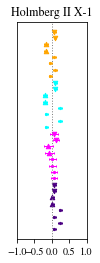

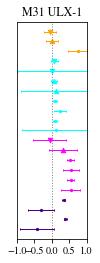

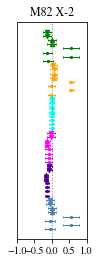

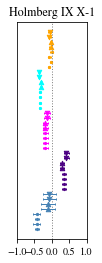

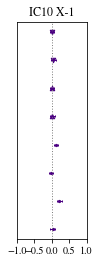

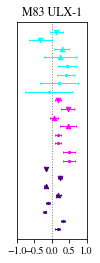

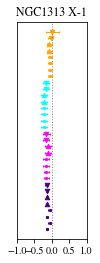

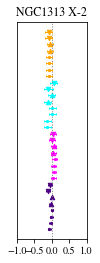

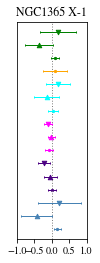

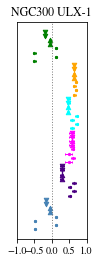

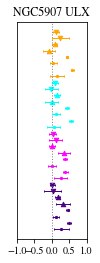

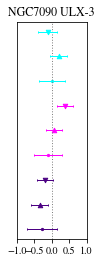

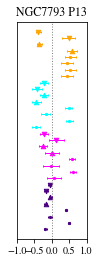

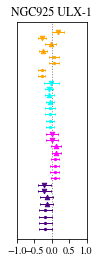

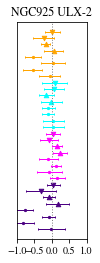

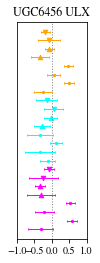

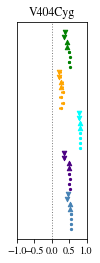

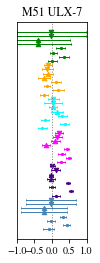

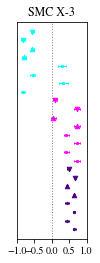

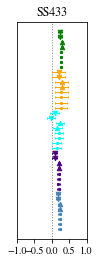

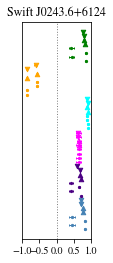

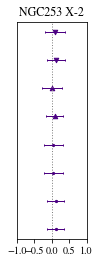

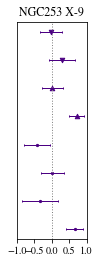

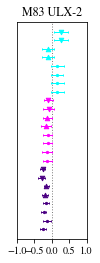

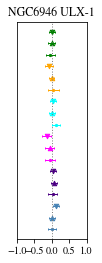

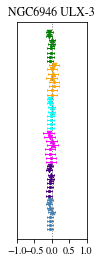

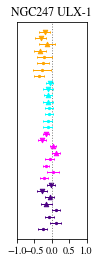

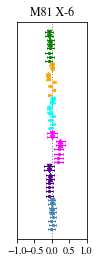

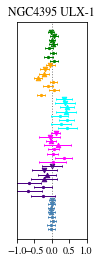

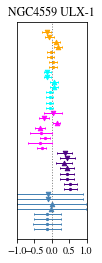

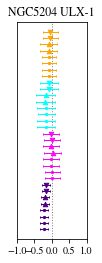

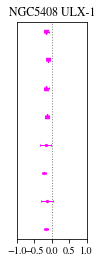

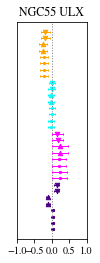

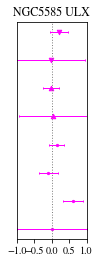

In [114]:
for simbad_name in df_fit_val['simbad_name'].unique():
    sub = df_fit_val_idx.loc[simbad_name,:,:,:,:]
    
    ysize = len(sub) * 0.1
    ysize = 4
    fig, ax = plt.subplots(1,1, figsize=(1.25,ysize), facecolor='white')
    ax.set_title(source_names_readable[simbad_name])
    ax.axvline(0, color='grey', ls='dotted', lw=1.0)
    last_len = 0
    for uvot_filter in sub.reset_index()['uvot_filter'].unique():
        sub2 = sub.loc[:,uvot_filter,:,:]
        ax.errorbar(sub2['r_mean'], y=np.arange(last_len, last_len+len(sub2), 1), xerr=sub2['r_std'], ls='none', lw=1.0, capsize=1.0,
                  color=filter_colors[uvot_filter], label=uvot_filter)
        
        # Plot the markers
        i = last_len
        for idx, row in sub2.iterrows():
            xrt_band = idx[0]
            ax.scatter(row['r_mean'],y=i,color=filter_colors[uvot_filter],marker=xrt_makers[xrt_band], s=20)
            i+=1
        last_len += len(sub2)
        ax.set_xlim(-1,1)
        
    ax.set_yticks([])
    ax.set_xticks([-1,-0.5,0.0,0.5,1.0])
    #ax.legend()
    plt.savefig(f'../figures/r_distr_by_source/pdf/{simbad_name}.pdf', bbox_inches='tight', pad_inches=0)
    plt.savefig(f'../figures/r_distr_by_source/png/{simbad_name}.png', bbox_inches='tight', pad_inches=0)
    plt.show()


In [11]:
filters = sub.reset_index()['uvot_filter'].unique()

NameError: name 'uvot_filters' is not defined

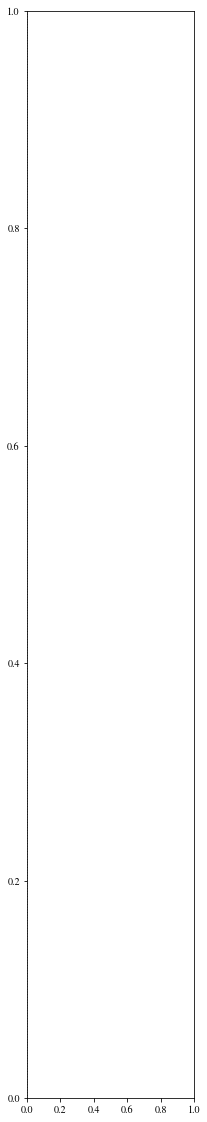

In [12]:
fig, ax = plt.subplots(1,1, figsize=(3,20))
last_len = 0
ax.axvline(0, color='grey', ls='dotted', lw=1.0)

unique_sources = df_fit_val['simbad_name'].unique()
sources_sorted = [s for s in source_distances_mpc.keys() if s in unique_sources]
for simbad_name in sources_sorted:
    #ax.set_title(simbad_name)
    
    sub = df_fit_val_idx.loc[simbad_name,:,:,:,:]
    
    unique_filters = sub.reset_index()['uvot_filter'].unique()
    filters_sorted = [f for f in uvot_filters if f in unique_filters]
    
    for uvot_filter in filters_sorted:
        sub2 = sub.loc[:,uvot_filter,:,:]
        ax.errorbar(sub2['r_mean'], y=np.arange(last_len, last_len+len(sub2), 1), xerr=sub2['r_std'], ls='none', lw=1.0, capsize=1.0,
                  color=filter_colors[uvot_filter])
        last_len += len(sub2)
    ax.axhline(last_len, color='black')
ax.set_xlim(-1,1)
ax.set_ylim(0,last_len+2)
ax.set_xlabel('r')
ax.legend()
plt.show()

In [ ]:
len(sources_sorted)/5

In [312]:
-total_rows/5

-306.2

In [369]:
# Sources to plot at the top
exclude_labels = ['[SRW2006b]_NGC_55_ULX', '[LM2005]_NGC_247_ULX1', 'NAME_UGC_6456_ULX',
                  '[SST2011]_J141939.39+564137.8', 'NAME_NGC_1365-X1']

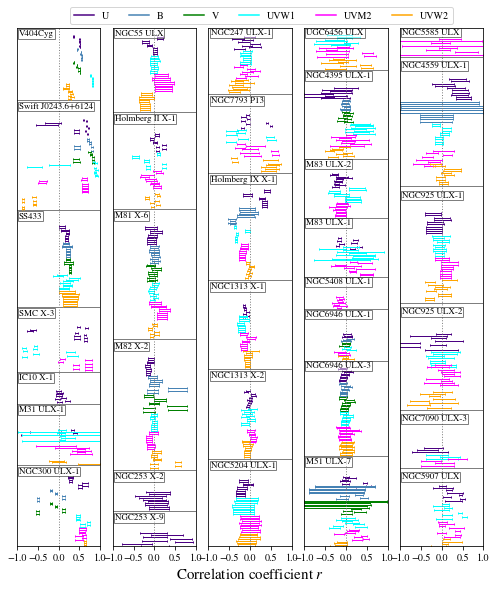

In [394]:
bbox_prop = dict(boxstyle='square', facecolor='white', alpha=0.5,pad=0.1)
total_rows = 1531
ncols = 5
fig, ax = plt.subplots(1,ncols, figsize=(\,8))

a = ax[0]
ax[0].text(x=-0.95, y=-5, s=source_names_readable[sources_sorted[0]], size=9, bbox=bbox_prop)
ax[1].text(x=-0.95, y=-333 -2, s=source_names_readable['[SRW2006b]_NGC_55_ULX'], size=9, bbox=bbox_prop)
ax[2].text(x=-0.95, y=-621 -4, s=source_names_readable['[LM2005]_NGC_247_ULX1'], size=9, bbox=bbox_prop)
ax[3].text(x=-0.95, y=-923 -5, s=source_names_readable['NAME_UGC_6456_ULX'], size=9, bbox=bbox_prop)
ax[4].text(x=-0.95, y=-1287-3, s=source_names_readable['[SST2011]_J141939.39+564137.8'], size=9, bbox=bbox_prop)



last_len = 0
unique_sources = df_fit_val['simbad_name'].unique()
sources_sorted = [s for s in list(source_distances_mpc.keys()) if s in unique_sources]
for i, simbad_name in enumerate(sources_sorted):
    #print(i, simbad_name, last_len)
    if last_len < -total_rows/5 * 1:
        a = ax[1]
    if last_len < -total_rows/5 * 2:
        a = ax[2]
    if last_len < -total_rows/5 * 3:
        a = ax[3]
    if last_len < -total_rows/5 * 4:
        a = ax[4]

    sub = df_fit_val_idx.loc[simbad_name,:,:,:,:]
    unique_filters = sub.reset_index()['uvot_filter'].unique()
    filters_sorted = [f for f in uvot_filters if f in unique_filters]
    
    
    for j, uvot_filter in enumerate(filters_sorted):
        if j==0:
            last_len-=12
        if j==len(filters_sorted)-1:
            a.axhline(last_len-1, color='black', lw=0.5)
            if i<len(sources_sorted)-1:
                name_to_plot = sources_sorted[i+1]
                if name_to_plot not in exclude_labels:
                    a.text(x=-0.95, y=last_len-6, s=source_names_readable[name_to_plot], size=9, bbox=bbox_prop)
                    
            
        sub2 = sub.loc[:,uvot_filter,:,:]
        a.errorbar(sub2['r_mean'], y=np.arange(last_len, last_len+len(sub2), 1), xerr=sub2['r_std'], ls='none', lw=1.0, capsize=1.0,
                  color=filter_colors[uvot_filter])
        last_len -= len(sub2)

ax[2].set_xlabel(r'Correlation coefficient $r$', fontsize=15)
for a in ax:
    a.set_yticks([])
    a.set_xlim(-1,1)
    a.set_xticks([-1,-0.5,0,0.5,1.0])
    a.axvline(0,lw=1.0,ls='dotted',color='grey')


ax[0].set_ylim(-333+12,0)
ax[1].set_ylim(-621+12,-333+2)
ax[2].set_ylim(-923+12,-621)
ax[3].set_ylim(-1287+12,-923)
ax[4].set_ylim(-1531+12,-1287)



    
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)

for f in uvot_filters:
    ax[2].plot(0,0,color=filter_colors[f], label=f)
    ax[2].legend(ncol=6, bbox_to_anchor=(3.0,1.05,0,0))

plt.savefig('test_figure.pdf', bbox_inches='tight')
plt.show()

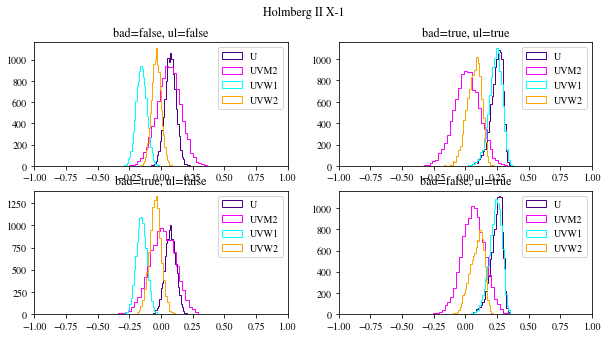

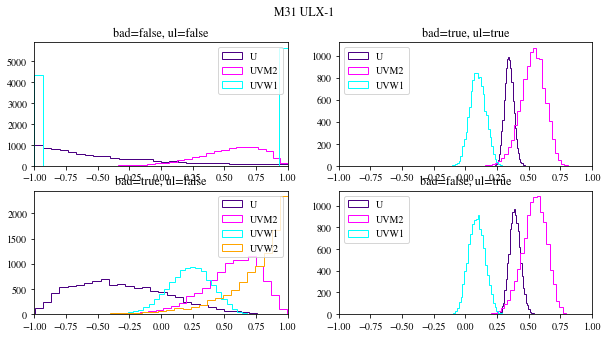

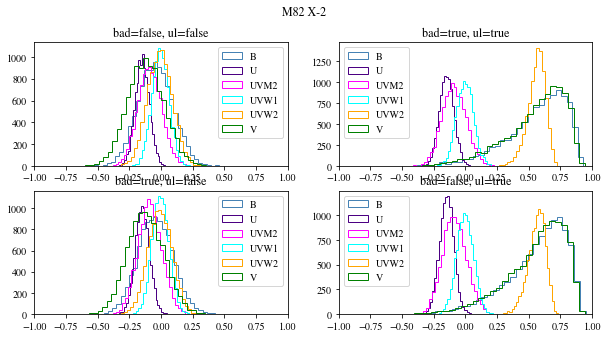

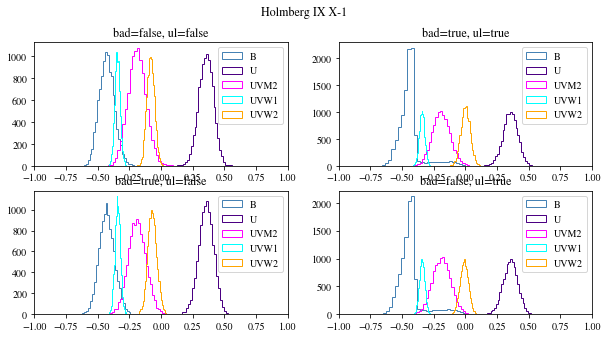

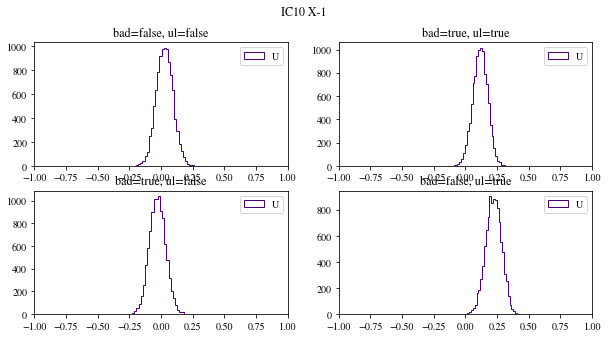

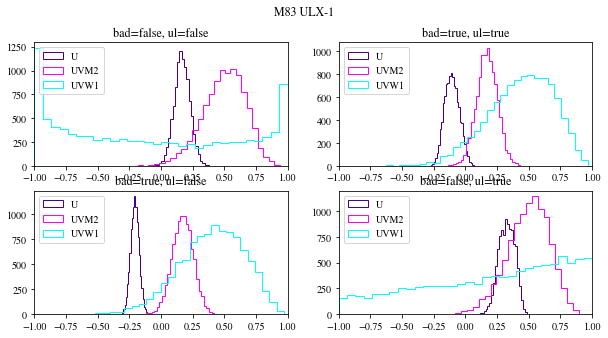

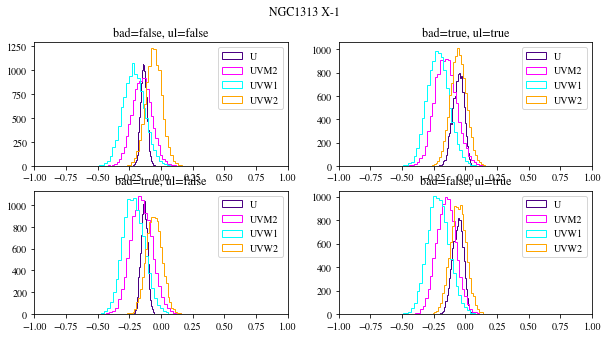

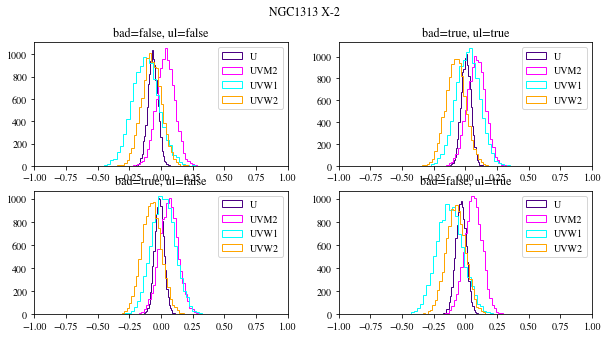

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


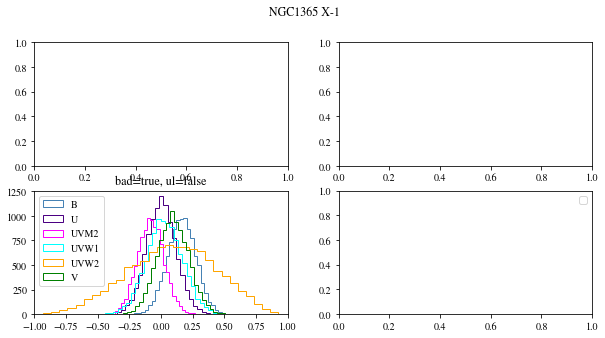

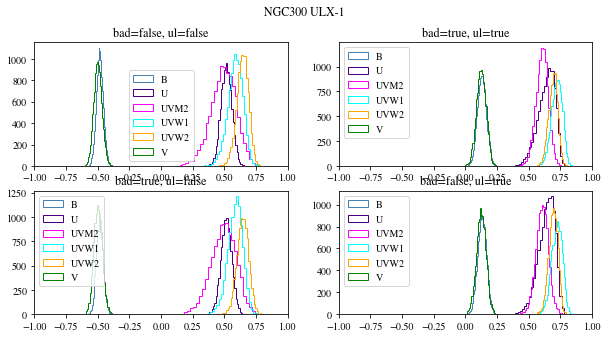

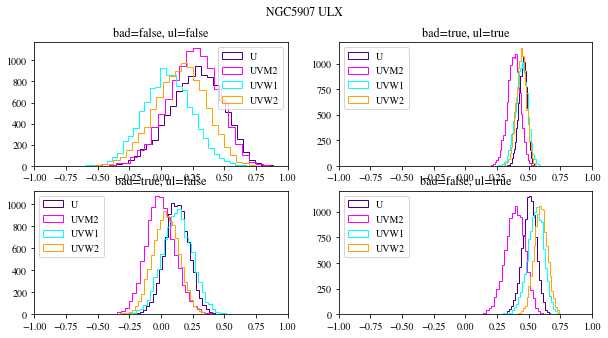

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


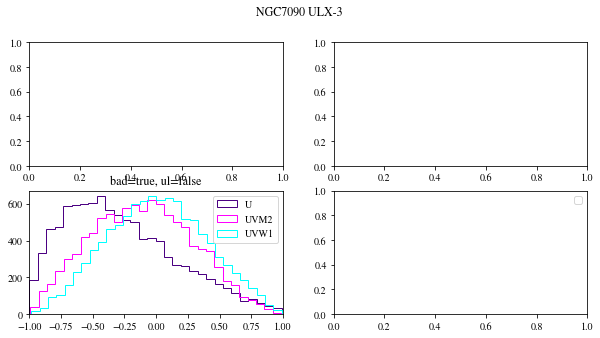

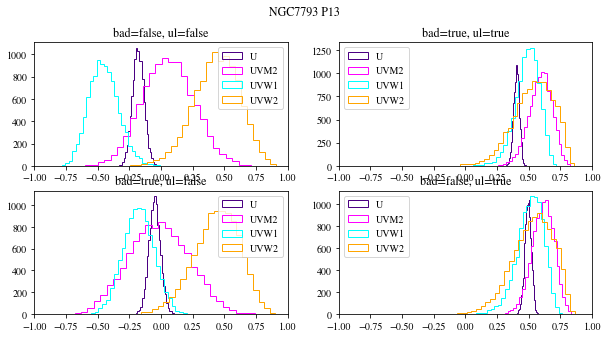

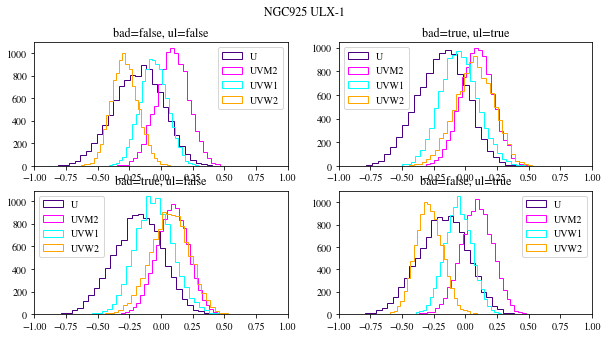

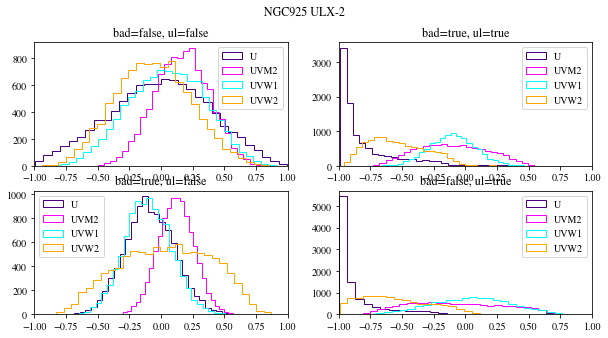

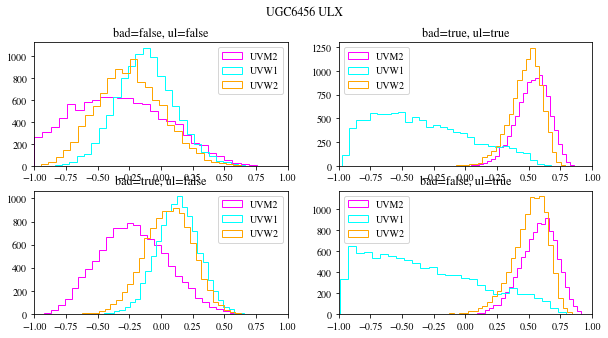

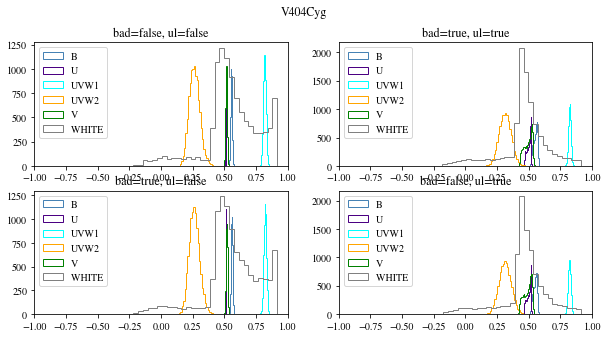

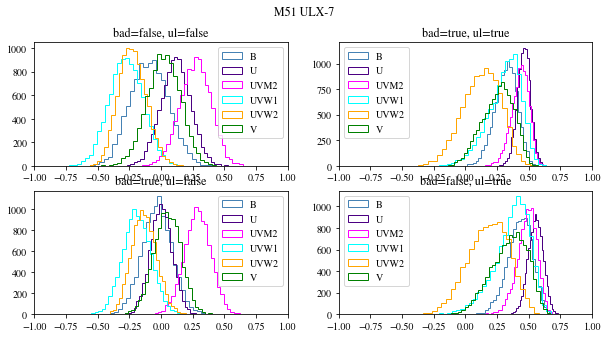

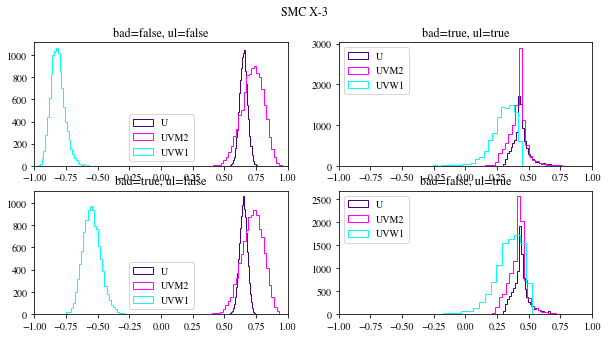

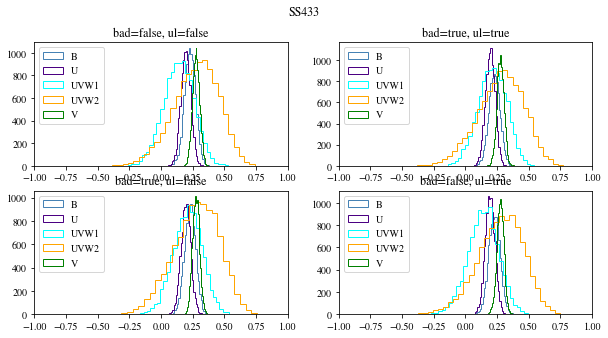

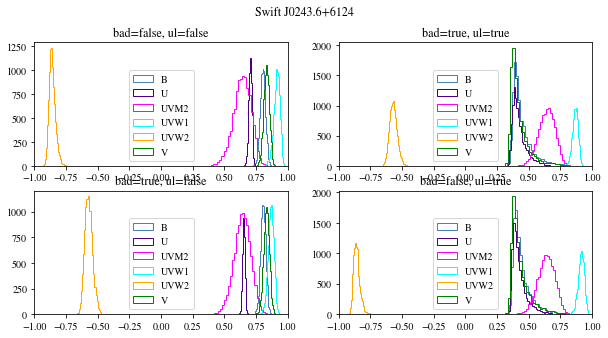

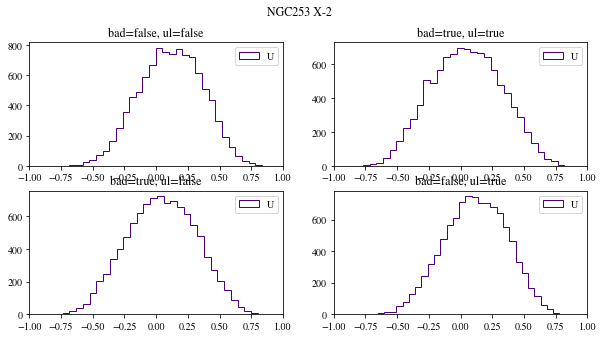

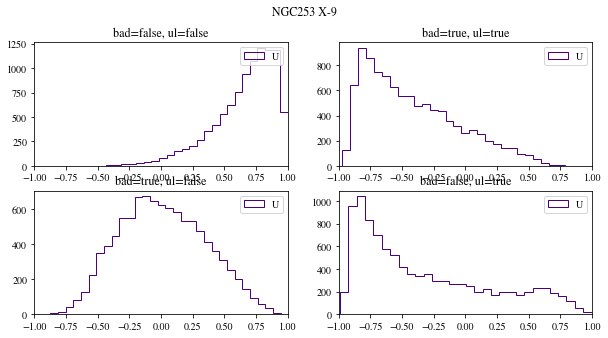

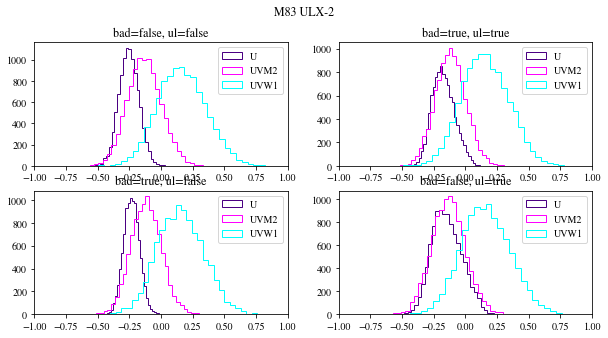

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


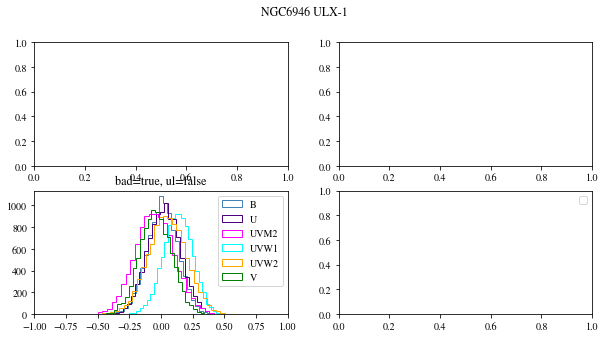

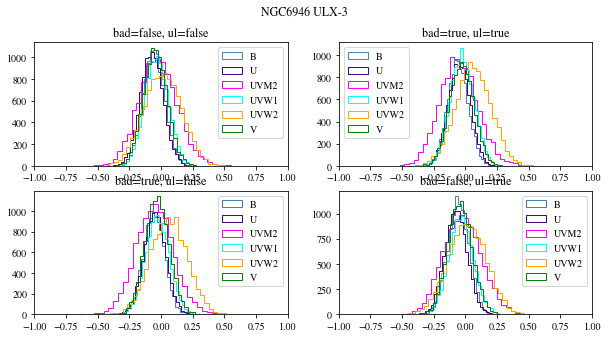

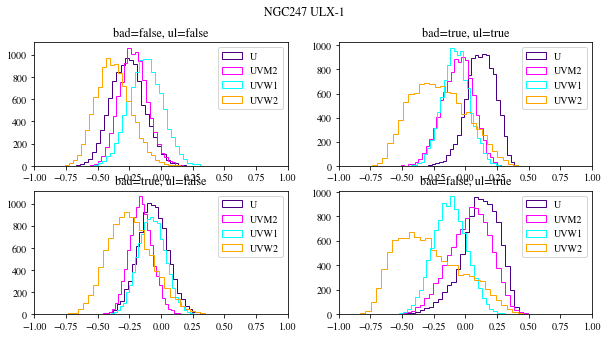

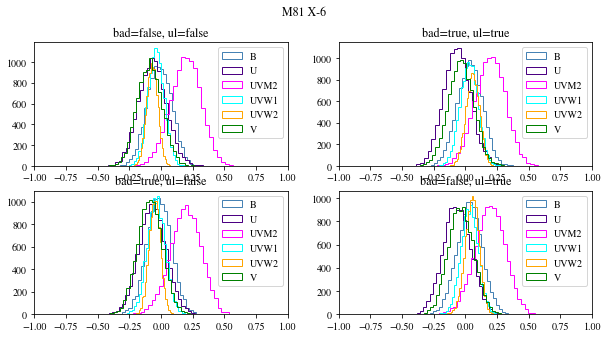

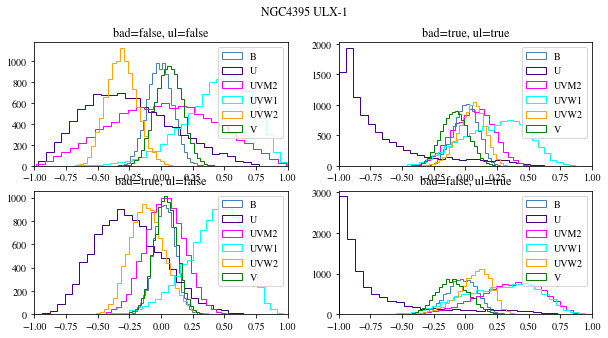

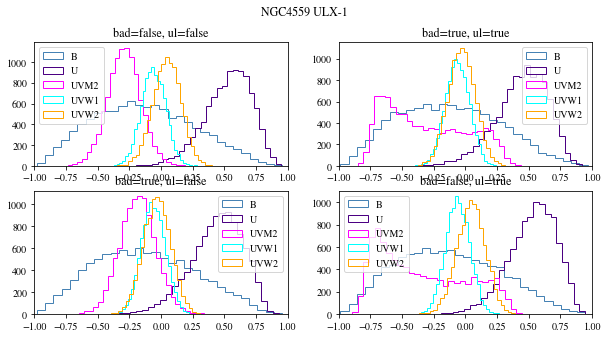

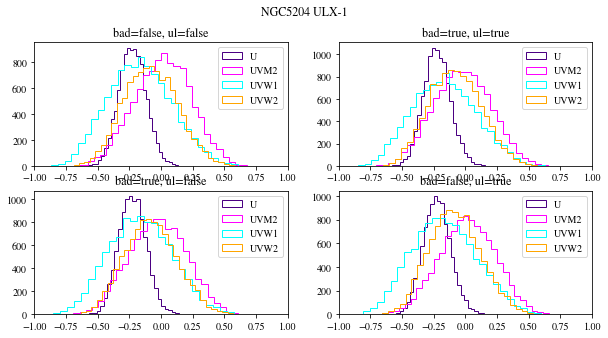

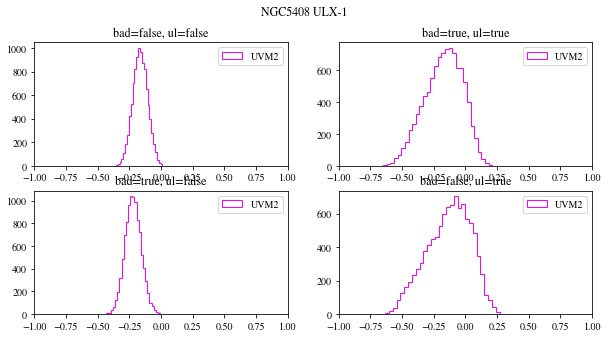

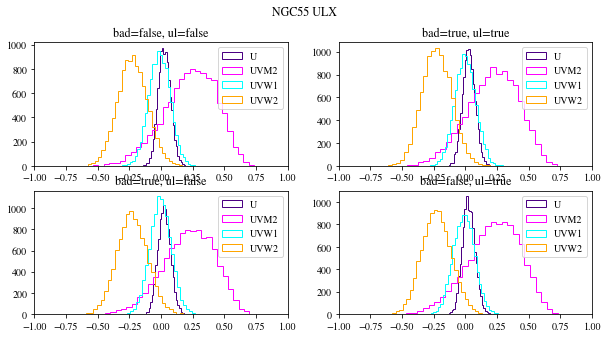

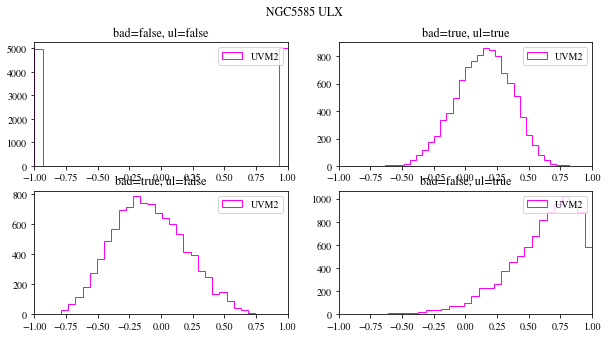

In [7]:
for simbad_name in df_fit_samples['simbad_name'].unique():
    readable_name  = source_names_readable[simbad_name]
    
    df_src         = df_fit_samples[df_fit_samples['simbad_name'] == simbad_name]
    df_src_FULL    = df_src[df_src['xrt_curve'] == 'FULL']
    df_src_FULL_FF = df_src_FULL[(df_src_FULL['include_bad'] == 'False') & (df_src_FULL['include_UL'] == 'False')]
    df_src_FULL_TT = df_src_FULL[(df_src_FULL['include_bad'] == 'True') & (df_src_FULL['include_UL'] == 'True')]
    df_src_FULL_TF = df_src_FULL[(df_src_FULL['include_bad'] == 'True') & (df_src_FULL['include_UL'] == 'False')]
    df_src_FULL_FT = df_src_FULL[(df_src_FULL['include_bad'] == 'False') & (df_src_FULL['include_UL'] == 'True')]


    fig, axes = plt.subplots(2,2,figsize=(10,5), facecolor='white')
    ax = axes.flatten()

    title = ['bad=false, ul=false', 'bad=true, ul=true', 'bad=true, ul=false', 'bad=false, ul=true']
    for i, df in enumerate([df_src_FULL_FF,df_src_FULL_TT,df_src_FULL_TF,df_src_FULL_FT]):
        for uvot_filter in df['uvot_filter'].unique():
            df_sub = df[df['uvot_filter'] == uvot_filter]
            df_sub['r'].hist(bins=30, color=filter_colors[uvot_filter], ax=ax[i], histtype='step', label=uvot_filter, grid=False)

            assert len(df_sub) == 10000
            ax[i].set_title(title[i])
            ax[i].legend()
            ax[i].set_xlim(-1,1)

    plt.suptitle(f'{readable_name}')
    plt.legend()
    plt.show()

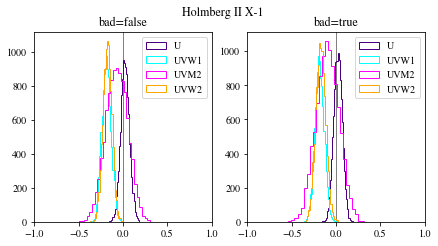

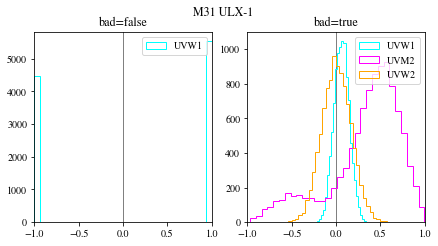

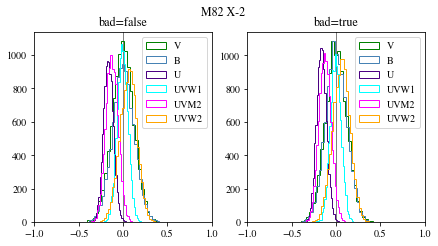

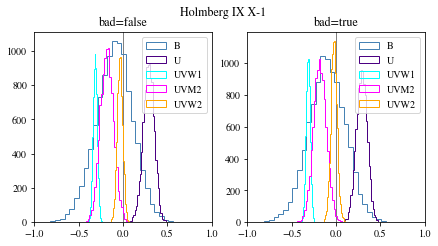

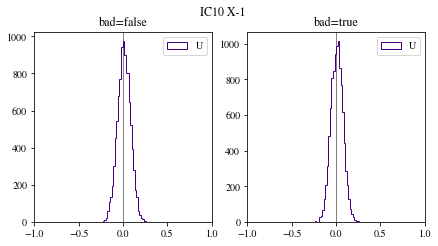

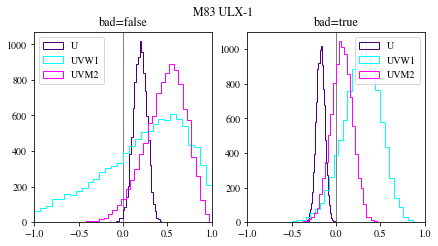

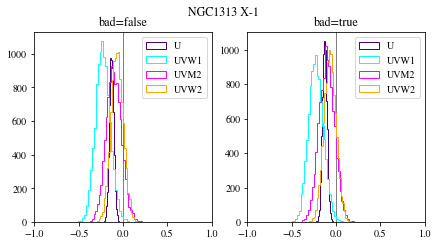

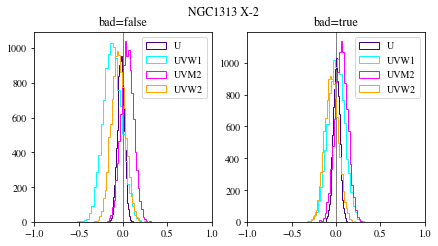

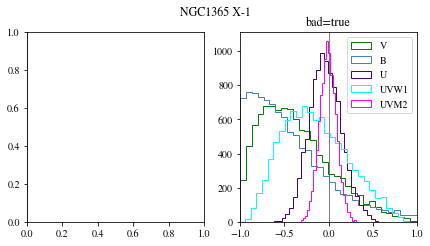

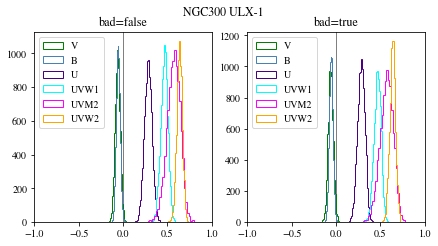

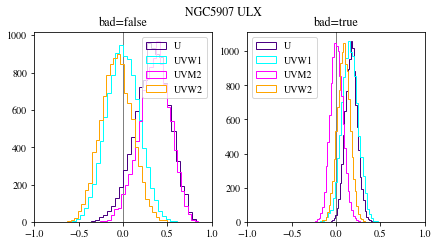

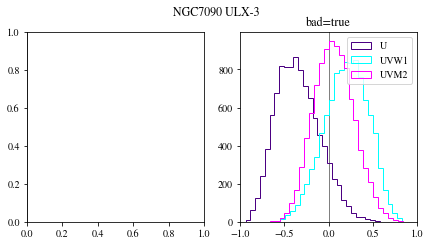

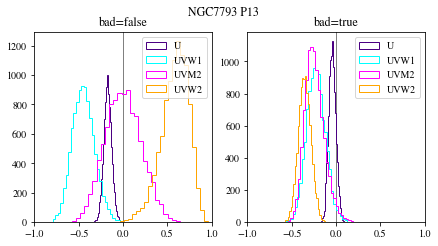

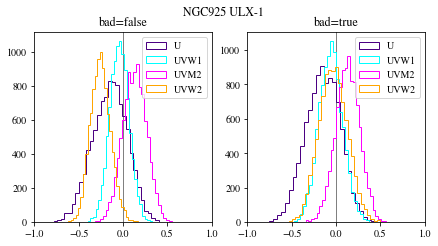

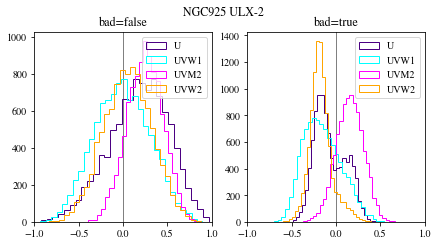

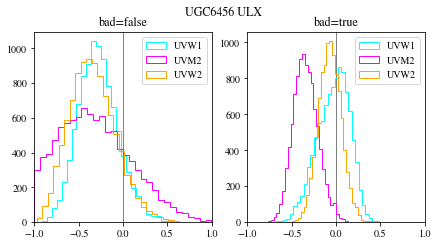

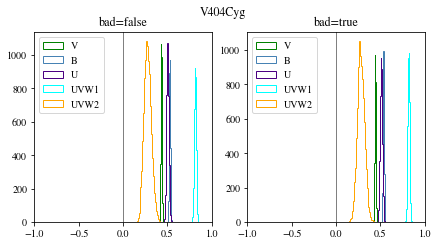

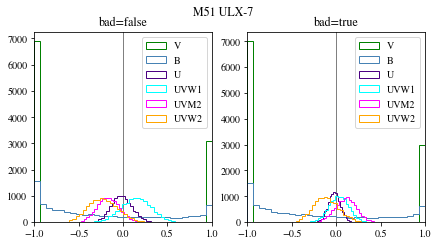

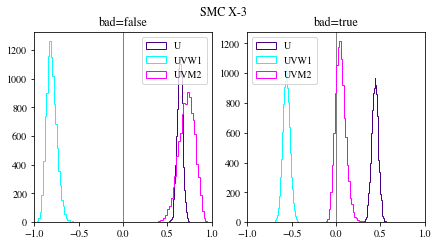

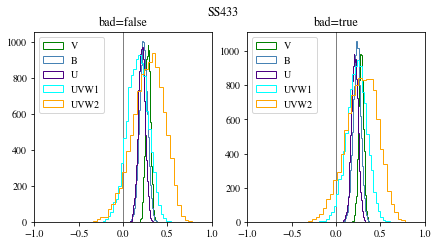

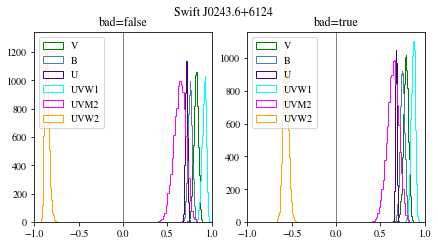

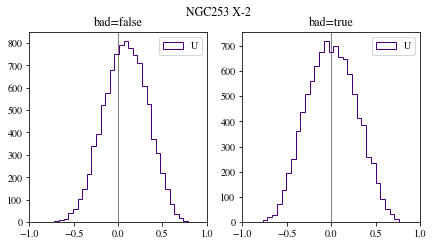

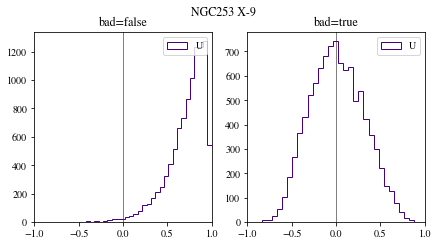

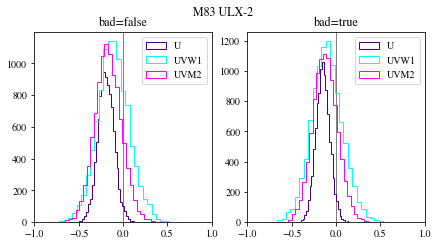

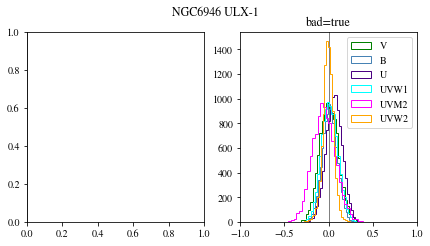

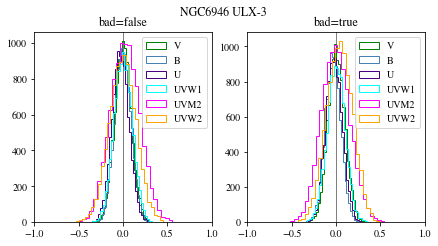

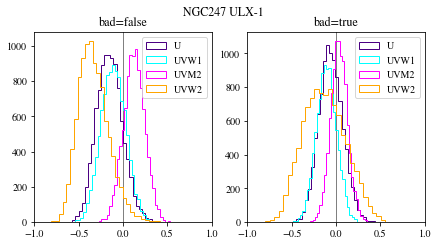

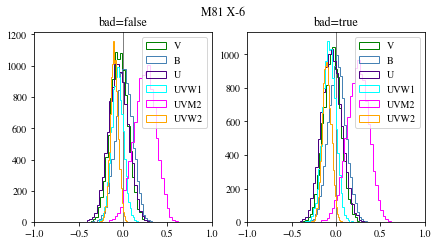

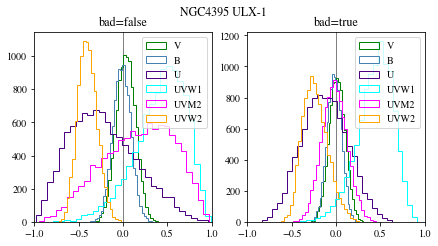

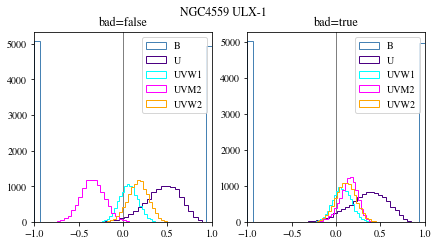

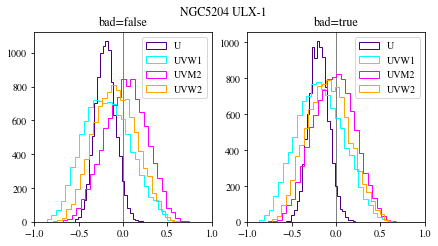

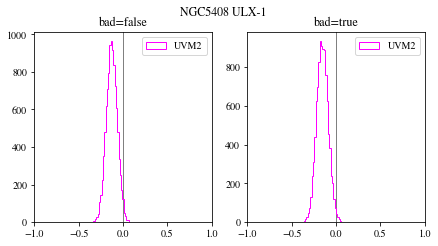

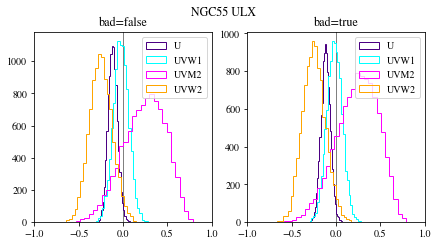

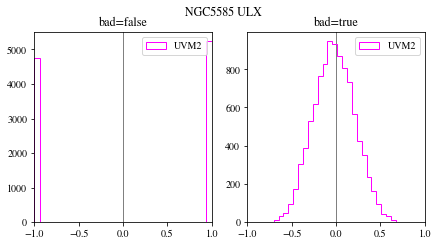

In [8]:
for simbad_name in df_fit_samples['simbad_name'].unique():
    readable_name  = source_names_readable[simbad_name]
    xrt_band = 'HARD'
    df_src         = df_fit_samples[df_fit_samples['simbad_name'] == simbad_name]
    df_src_BAND    = df_src[df_src['xrt_curve'] == xrt_band]
    df_src_BAND_FF = df_src_BAND[(df_src_BAND['include_bad'] == 'False') & (df_src_BAND['include_UL'] == 'False')]
    df_src_BAND_TF = df_src_BAND[(df_src_BAND['include_bad'] == 'True') & (df_src_BAND['include_UL'] == 'False')]


    fig, ax = plt.subplots(1,2,figsize=(7,3.5), facecolor='white')
    
    title = ['bad=false', 'bad=true',]
    for i, df in enumerate([df_src_BAND_FF,df_src_BAND_TF]):
        ax[i].axvline(0, color='grey', lw=1.0)
        
        filters_sorted = [f for f in ['V','B','U','UVW1','UVM2','UVW2'] if f in df['uvot_filter'].unique()]

        for uvot_filter in filters_sorted:
            df_sub = df[df['uvot_filter'] == uvot_filter]
            df_sub['r'].hist(bins=30, color=filter_colors[uvot_filter], ax=ax[i], histtype='step', label=uvot_filter, grid=False)

            assert len(df_sub) == 10000
            ax[i].set_title(title[i])
            ax[i].legend()
            ax[i].set_xlim(-1,1)
            

    plt.suptitle(f'{readable_name}')
    plt.legend()
    plt.savefig(f'../figures/r_distributions/{readable_name}_{xrt_band}_r.pdf')
    plt.savefig(f'../figures/r_distributions/{readable_name}_{xrt_band}_r.png')
    
    plt.show()

NGC300 ULX-1                            -0.0619	0.0282	2.1981
NGC300 ULX-1                            -0.0615	0.0285	2.1533
V404Cyg                                 0.4322	0.0063	68.0666
V404Cyg                                 0.4421	0.0063	70.6527
SS433                                   0.2801	0.0281	9.9825
SS433                                   0.2807	0.0277	10.1228
Swift J0243.6+6124                      0.8203	0.0257	31.9682
Swift J0243.6+6124                      0.7850	0.0278	28.2629


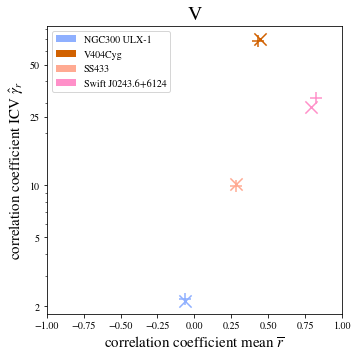

NGC300 ULX-1                            -0.0571	0.0214	2.6647
NGC300 ULX-1                            -0.0572	0.0211	2.7084
V404Cyg                                 0.5265	0.0065	81.0422
V404Cyg                                 0.5352	0.0064	83.6761
SS433                                   0.2318	0.0448	5.1699
SS433                                   0.2326	0.0440	5.2918
Swift J0243.6+6124                      0.7528	0.0246	30.5445
Swift J0243.6+6124                      0.7458	0.0248	30.1249


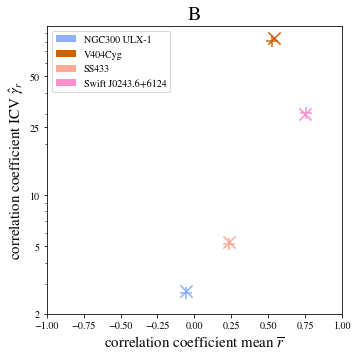

M82 X-2                                 -0.1653	0.0554	2.9840
M82 X-2                                 -0.1651	0.0556	2.9705
Holmberg IX X-1                         0.2861	0.0619	4.6230
Holmberg IX X-1                         0.2865	0.0615	4.6556
M83 ULX-1                               0.1915	0.0753	2.5424
M83 ULX-1                               -0.1764	0.0481	3.6676
NGC1313 X-1                             -0.1296	0.0251	5.1589
NGC1313 X-1                             -0.1279	0.0263	4.8673
NGC300 ULX-1                            0.2824	0.0418	6.7586
NGC300 ULX-1                            0.2820	0.0416	6.7785
NGC5907 ULX                             0.1697	0.0681	2.4925
NGC7793 P13                             -0.1744	0.0468	3.7235
V404Cyg                                 0.5030	0.0130	38.6416
V404Cyg                                 0.5083	0.0127	39.9546
SMC X-3                                 0.6379	0.0321	19.8530
SMC X-3                                 0.4351	0.0369	11.7834
SS433         

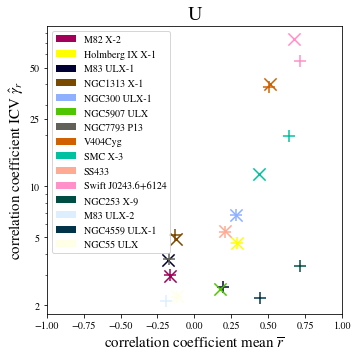

Holmberg II X-1                         -0.1880	0.0513	3.6638
Holmberg II X-1                         -0.1886	0.0516	3.6535
Holmberg IX X-1                         -0.3155	0.0230	13.7026
Holmberg IX X-1                         -0.3152	0.0231	13.6697
NGC1313 X-1                             -0.2288	0.0847	2.7011
NGC1313 X-1                             -0.2273	0.0832	2.7322
NGC300 ULX-1                            0.4640	0.0396	11.7166
NGC300 ULX-1                            0.4636	0.0396	11.6961
NGC7793 P13                             -0.4465	0.1263	3.5346
NGC7793 P13                             -0.2273	0.1052	2.1617
V404Cyg                                 0.8139	0.0110	73.7702
V404Cyg                                 0.8182	0.0107	76.5931
SMC X-3                                 -0.8066	0.0582	13.8612
SMC X-3                                 -0.5619	0.0413	13.5911
SS433                                   0.2294	0.1125	2.0385
Swift J0243.6+6124                      0.9117	0.0243	37.4718
Swift

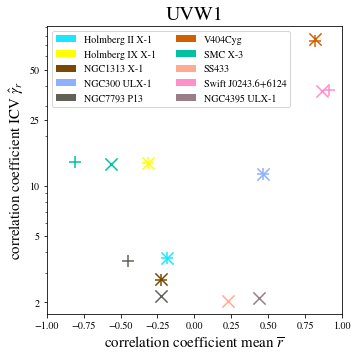

Holmberg IX X-1                         -0.1834	0.0739	2.4812
Holmberg IX X-1                         -0.1843	0.0735	2.5069
M83 ULX-1                               0.4726	0.2301	2.0536
NGC300 ULX-1                            0.5668	0.0748	7.5803
NGC300 ULX-1                            0.5668	0.0743	7.6243
NGC5907 ULX                             0.3514	0.1725	2.0365
NGC7793 P13                             -0.2428	0.1097	2.2131
UGC6456 ULX                             -0.3439	0.1383	2.4859
SMC X-3                                 0.7139	0.0896	7.9695
Swift J0243.6+6124                      0.6359	0.0682	9.3251
Swift J0243.6+6124                      0.6379	0.0655	9.7320
M81 X-6                                 0.2449	0.1218	2.0115
NGC4559 ULX-1                           -0.3420	0.1377	2.4831
NGC5408 ULX-1                           -0.1293	0.0617	2.0963
NGC5408 ULX-1                           -0.1563	0.0643	2.4317


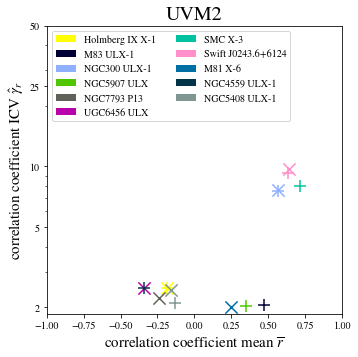

Holmberg II X-1                         -0.1759	0.0503	3.4984
Holmberg II X-1                         -0.1741	0.0557	3.1262
NGC300 ULX-1                            0.6354	0.0320	19.8863
NGC300 ULX-1                            0.6350	0.0321	19.7906
NGC7793 P13                             0.5797	0.1550	3.7400
NGC7793 P13                             -0.3560	0.0704	5.0604
NGC925 ULX-1                            -0.2562	0.1122	2.2844
V404Cyg                                 0.2771	0.0407	6.8028
V404Cyg                                 0.2775	0.0408	6.8079
Swift J0243.6+6124                      -0.8594	0.0254	33.8618
Swift J0243.6+6124                      -0.5693	0.0319	17.8292
M81 X-6                                 -0.1007	0.0436	2.3120
M81 X-6                                 -0.1057	0.0494	2.1385
NGC4395 ULX-1                           -0.4006	0.1093	3.6634


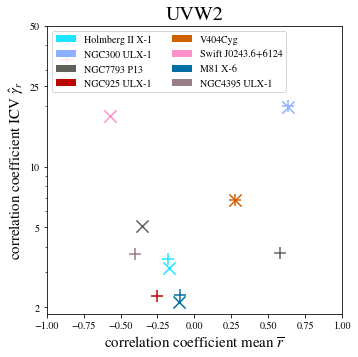

V404Cyg                                 0.3620	0.1554	2.3289
V404Cyg                                 0.3687	0.1566	2.3551


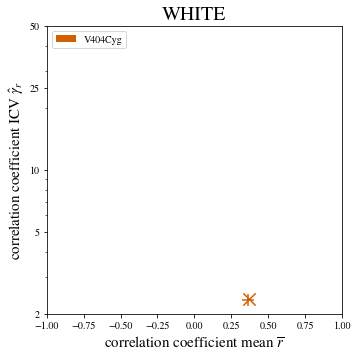

In [9]:
for uvot_filter in ['V','B','U','UVW1','UVM2','UVW2','WHITE']:
    names_to_plot = []
    fig, ax = plt.subplots(1,1,figsize=(5.3,5.3), facecolor='white')
    ax.set_title(f'{uvot_filter}', size=20)
    ax.set_xlabel(r'correlation coefficient mean $\overline{r}$', size=15)
    ax.set_ylabel(r'correlation coefficient ICV $\hat{\gamma}_{r}$', size=15)
    
    ax.set_xlim(-1,1)
    
    sub1 = df_fit_samples[df_fit_samples['uvot_filter'] == uvot_filter]
    
    for simbad_name in sub1['simbad_name'].unique():
        readable_name  = source_names_readable[simbad_name]
        sub2 = sub1[sub1['simbad_name'] == simbad_name]
        for xrt_band in ['HARD']:
            sub3   = sub2[sub2['xrt_curve'] == xrt_band]
            sub_FF = sub3[(sub3['include_bad'] == 'False') & (sub3['include_UL'] == 'False')]
            sub_TF = sub3[(sub3['include_bad'] == 'True') & (sub3['include_UL'] == 'False')]

        
            title = ['bad=false', 'bad=true']

            markers = {'FULL_FF': '+',
                       'SOFT_FF': r'$\mathrm{S}$',
                       'HARD_FF': '+',
                       'FULL_TF': r'$\mathrm{\overline{F}}$',
                       'SOFT_TF': r'$\mathrm{\overline{S}}$',
                       'HARD_TF': 'x'}
            pars = ['FF','TF']
            for i, df in enumerate([sub_FF,sub_TF]):
                marker = markers[f'{xrt_band}_{pars[i]}']
                r        = df['r'].mean()
                r_std    = df['r'].std()
                r_nsig   = abs(r / r_std)

                if (r_nsig < 2) or np.isnan(r_nsig):
                    continue
                else:
                    ax.scatter(r, r_nsig, marker=marker, color=source_name_colors[simbad_name], s=150)
                    names_to_plot.append(simbad_name)
                    print(f'{readable_name:<40}{r:.4f}\t{r_std:.4f}\t{r_nsig:.4f}')

            
    ax.set_yscale('log')
    ax.set_yticks([2,5,10,25,50], labels=[2,5,10,25,50])
    
    
    names_to_plot = list(dict.fromkeys(names_to_plot))
    legend_elements = [Patch(facecolor=source_name_colors[simbad_name], label=source_names_readable[simbad_name]) for simbad_name in names_to_plot]
    
    
    if uvot_filter in ['UVW1','UVM2','UVW2']:
        ax.legend(handles=legend_elements, ncol=2, loc='upper left')
    else:
        ax.legend(handles=legend_elements, ncol=1, loc='upper left')
        
    plt.savefig(f'../figures/r_vs_r_sig/{uvot_filter}.pdf', bbox_inches='tight')
    plt.savefig(f'../figures/r_vs_r_sig/{uvot_filter}.png', bbox_inches='tight')
    plt.show()

In [10]:
# For each source, Plot r vs r_sig for each band

Holmberg_II_X-1
Holmberg II X-1                         U                             0.0205	0.0501	0.410210000
Holmberg II X-1                         U                             0.0206	0.0492	0.419610000
Holmberg II X-1                         UVW1                          -0.1880	0.0513	3.663810000
Holmberg II X-1                         UVW1                          -0.1886	0.0516	3.653510000
Holmberg II X-1                         UVM2                          -0.0713	0.1242	0.573910000
Holmberg II X-1                         UVM2                          -0.0983	0.1300	0.756310000
Holmberg II X-1                         UVW2                          -0.1759	0.0503	3.498410000
Holmberg II X-1                         UVW2                          -0.1741	0.0557	3.126210000


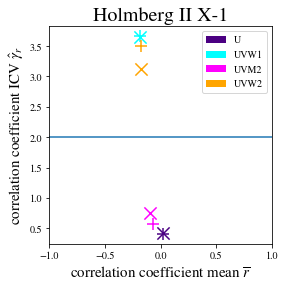

M31_ULX-1
M31 ULX-1                               UVW1                          0.1084	0.9942	0.109010000
M31 ULX-1                               UVW1                          0.0595	0.0855	0.695510000
M31 ULX-1                               UVM2                          0.3256	0.4064	0.801110000
M31 ULX-1                               UVW2                          0.0046	0.1634	0.028010000


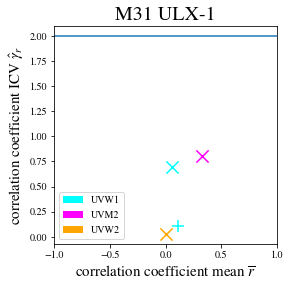

M82_X-2
M82 X-2                                 V                             -0.0024	0.1202	0.020210000
M82 X-2                                 V                             -0.0017	0.1190	0.014210000
M82 X-2                                 B                             0.0004	0.1206	0.003110000
M82 X-2                                 B                             -0.0003	0.1170	0.002810000
M82 X-2                                 U                             -0.1653	0.0554	2.984010000
M82 X-2                                 U                             -0.1651	0.0556	2.970510000
M82 X-2                                 UVW1                          -0.0062	0.0610	0.102410000
M82 X-2                                 UVW1                          -0.0069	0.0603	0.114710000
M82 X-2                                 UVM2                          -0.1257	0.0678	1.854310000
M82 X-2                                 UVM2                          -0.1259	0.0673	1.870510000
M82 X-2                

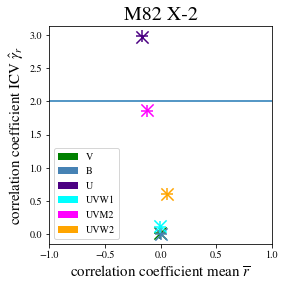

NAME_Holmberg_IX_X-1
Holmberg IX X-1                         B                             -0.0996	0.2050	0.486110000
Holmberg IX X-1                         B                             -0.1038	0.2061	0.503810000
Holmberg IX X-1                         U                             0.2861	0.0619	4.623010000
Holmberg IX X-1                         U                             0.2865	0.0615	4.655610000
Holmberg IX X-1                         UVW1                          -0.3155	0.0230	13.702610000
Holmberg IX X-1                         UVW1                          -0.3152	0.0231	13.669710000
Holmberg IX X-1                         UVM2                          -0.1834	0.0739	2.481210000
Holmberg IX X-1                         UVM2                          -0.1843	0.0735	2.506910000
Holmberg IX X-1                         UVW2                          -0.0352	0.0310	1.133710000
Holmberg IX X-1                         UVW2                          -0.0250	0.0356	0.703810000


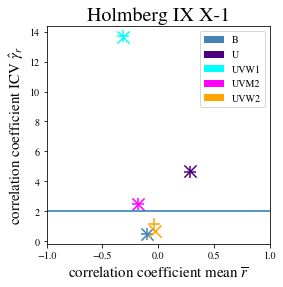

NAME_IC_10_X-1
IC10 X-1                                U                             0.0093	0.0731	0.127110000
IC10 X-1                                U                             0.0080	0.0674	0.119410000


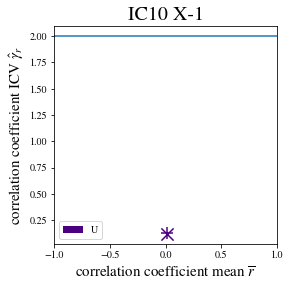

NAME_M83_ULX-1
M83 ULX-1                               U                             0.1915	0.0753	2.542410000
M83 ULX-1                               U                             -0.1764	0.0481	3.667610000
M83 ULX-1                               UVW1                          0.2338	0.4657	0.502110000
M83 ULX-1                               UVW1                          0.2846	0.2089	1.362610000
M83 ULX-1                               UVM2                          0.4726	0.2301	2.053610000
M83 ULX-1                               UVM2                          0.0638	0.1200	0.532210000


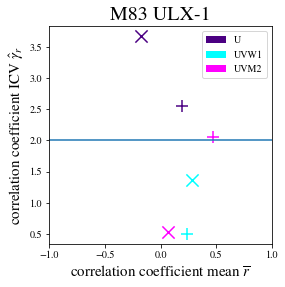

NAME_NGC_1313_X-1
NGC1313 X-1                             U                             -0.1296	0.0251	5.158910000
NGC1313 X-1                             U                             -0.1279	0.0263	4.867310000
NGC1313 X-1                             UVW1                          -0.2288	0.0847	2.701110000
NGC1313 X-1                             UVW1                          -0.2273	0.0832	2.732210000
NGC1313 X-1                             UVM2                          -0.1057	0.0855	1.235910000
NGC1313 X-1                             UVM2                          -0.1076	0.0869	1.238210000
NGC1313 X-1                             UVW2                          -0.0685	0.0687	0.998110000
NGC1313 X-1                             UVW2                          -0.0676	0.0688	0.982910000


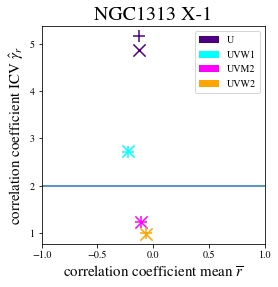

NAME_NGC_1313_X-2
NGC1313 X-2                             U                             -0.0261	0.0392	0.666310000
NGC1313 X-2                             U                             0.0029	0.0375	0.078010000
NGC1313 X-2                             UVW1                          -0.1216	0.1048	1.160010000
NGC1313 X-2                             UVW1                          -0.0007	0.0937	0.007610000
NGC1313 X-2                             UVM2                          0.0454	0.0713	0.636710000
NGC1313 X-2                             UVM2                          0.0564	0.0722	0.781710000
NGC1313 X-2                             UVW2                          -0.0551	0.0788	0.698710000
NGC1313 X-2                             UVW2                          -0.0531	0.0773	0.686710000


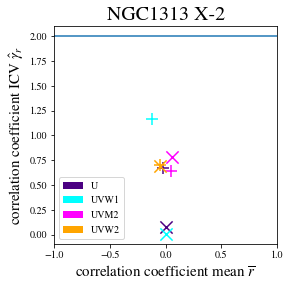

NAME_NGC_1365-X1
NGC1365 X-1                             V                             -0.3619	0.3979	0.909510000
NGC1365 X-1                             B                             -0.4375	0.4325	1.011710000
NGC1365 X-1                             U                             -0.0368	0.1817	0.202610000
NGC1365 X-1                             UVW1                          -0.1496	0.3647	0.410110000
NGC1365 X-1                             UVM2                          -0.0115	0.0963	0.119810000


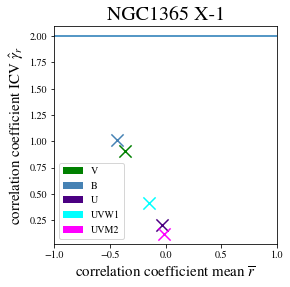

NAME_NGC_300_ULX1
NGC300 ULX-1                            V                             -0.0619	0.0282	2.198110000
NGC300 ULX-1                            V                             -0.0615	0.0285	2.153310000
NGC300 ULX-1                            B                             -0.0571	0.0214	2.664710000
NGC300 ULX-1                            B                             -0.0572	0.0211	2.708410000
NGC300 ULX-1                            U                             0.2824	0.0418	6.758610000
NGC300 ULX-1                            U                             0.2820	0.0416	6.778510000
NGC300 ULX-1                            UVW1                          0.4640	0.0396	11.716610000
NGC300 ULX-1                            UVW1                          0.4636	0.0396	11.696110000
NGC300 ULX-1                            UVM2                          0.5668	0.0748	7.580310000
NGC300 ULX-1                            UVM2                          0.5668	0.0743	7.624310000
NGC300 ULX-1    

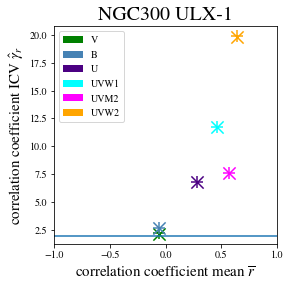

NAME_NGC_5907_ULX
NGC5907 ULX                             U                             0.3240	0.1936	1.673810000
NGC5907 ULX                             U                             0.1697	0.0681	2.492510000
NGC5907 ULX                             UVW1                          -0.0052	0.1819	0.028810000
NGC5907 ULX                             UVW1                          0.1547	0.0920	1.681310000
NGC5907 ULX                             UVM2                          0.3514	0.1725	2.036510000
NGC5907 ULX                             UVM2                          0.0063	0.0732	0.085710000
NGC5907 ULX                             UVW2                          -0.0748	0.1764	0.424010000
NGC5907 ULX                             UVW2                          0.0841	0.0714	1.177910000


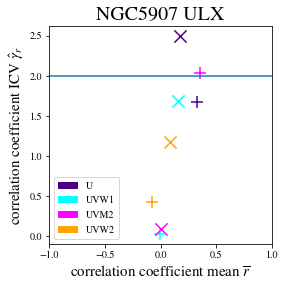

NAME_NGC_7090_ULX3
NGC7090 ULX-3                           U                             -0.3440	0.2478	1.388410000
NGC7090 ULX-3                           UVW1                          0.1954	0.2458	0.795310000
NGC7090 ULX-3                           UVM2                          0.0591	0.2255	0.262010000


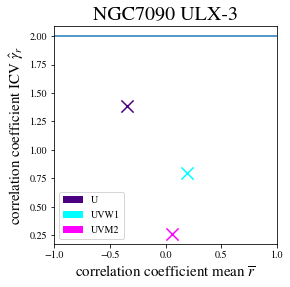

NAME_NGC_7793_P13
NGC7793 P13                             U                             -0.1744	0.0468	3.723510000
NGC7793 P13                             U                             -0.0437	0.0399	1.093910000
NGC7793 P13                             UVW1                          -0.4465	0.1263	3.534610000
NGC7793 P13                             UVW1                          -0.2273	0.1052	2.161710000
NGC7793 P13                             UVM2                          -0.0011	0.2013	0.005610000
NGC7793 P13                             UVM2                          -0.2428	0.1097	2.213110000
NGC7793 P13                             UVW2                          0.5797	0.1550	3.740010000
NGC7793 P13                             UVW2                          -0.3560	0.0704	5.060410000


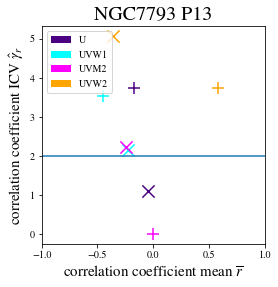

NAME_NGC_925_ULX-1
NGC925 ULX-1                            U                             -0.1503	0.1941	0.774510000
NGC925 ULX-1                            U                             -0.1505	0.1923	0.782910000
NGC925 ULX-1                            UVW1                          -0.0429	0.1082	0.396210000
NGC925 ULX-1                            UVW1                          -0.0652	0.1334	0.488810000
NGC925 ULX-1                            UVM2                          0.1276	0.1327	0.961310000
NGC925 ULX-1                            UVM2                          0.1268	0.1345	0.943010000
NGC925 ULX-1                            UVW2                          -0.2562	0.1122	2.284410000
NGC925 ULX-1                            UVW2                          -0.0335	0.1584	0.211210000


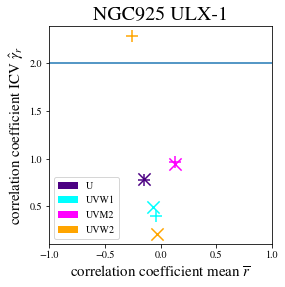

NAME_NGC_925_ULX-2
NGC925 ULX-2                            U                             0.1705	0.3342	0.510210000
NGC925 ULX-2                            U                             -0.0704	0.1756	0.400810000
NGC925 ULX-2                            UVW1                          -0.0117	0.3101	0.037610000
NGC925 ULX-2                            UVW1                          -0.1545	0.2114	0.731010000
NGC925 ULX-2                            UVM2                          0.2434	0.2001	1.216710000
NGC925 ULX-2                            UVM2                          0.1517	0.1545	0.981810000
NGC925 ULX-2                            UVW2                          0.0527	0.2695	0.195510000
NGC925 ULX-2                            UVW2                          -0.1730	0.1295	1.336110000


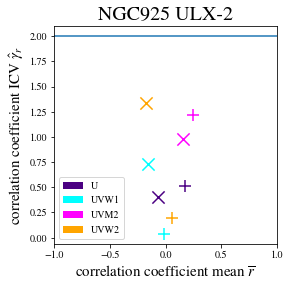

NAME_UGC_6456_ULX
UGC6456 ULX                             UVW1                          -0.2805	0.2247	1.248410000
UGC6456 ULX                             UVW1                          -0.0349	0.1804	0.193310000
UGC6456 ULX                             UVM2                          -0.3106	0.3961	0.784310000
UGC6456 ULX                             UVM2                          -0.3439	0.1383	2.485910000
UGC6456 ULX                             UVW2                          -0.3403	0.2616	1.300510000
UGC6456 ULX                             UVW2                          -0.0693	0.1275	0.543710000


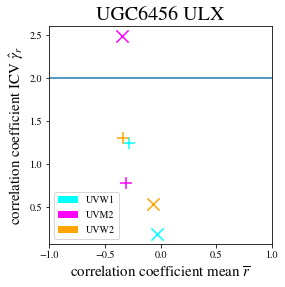

NOVA_Cyg_1989
V404Cyg                                 V                             0.4322	0.0063	68.066610000
V404Cyg                                 V                             0.4421	0.0063	70.652710000
V404Cyg                                 B                             0.5265	0.0065	81.042210000
V404Cyg                                 B                             0.5352	0.0064	83.676110000
V404Cyg                                 U                             0.5030	0.0130	38.641610000
V404Cyg                                 U                             0.5083	0.0127	39.954610000
V404Cyg                                 UVW1                          0.8139	0.0110	73.770210000
V404Cyg                                 UVW1                          0.8182	0.0107	76.593110000
V404Cyg                                 UVW2                          0.2771	0.0407	6.802810000
V404Cyg                                 UVW2                          0.2775	0.0408	6.807910000
V404Cyg           

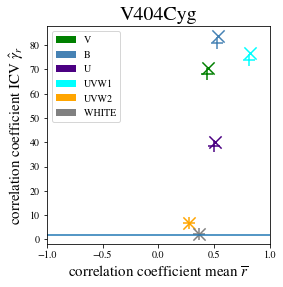

RX_J133001+47137
M51 ULX-7                               V                             -0.3810	0.9246	0.412110000
M51 ULX-7                               V                             -0.4026	0.9154	0.439810000
M51 ULX-7                               B                             -0.2247	0.6634	0.338710000
M51 ULX-7                               B                             -0.2207	0.6638	0.332410000
M51 ULX-7                               U                             -0.0188	0.1164	0.161710000
M51 ULX-7                               U                             -0.0206	0.0688	0.299310000
M51 ULX-7                               UVW1                          0.1431	0.1683	0.850610000
M51 ULX-7                               UVW1                          0.0279	0.1120	0.249510000
M51 ULX-7                               UVM2                          -0.1640	0.1264	1.297410000
M51 ULX-7                               UVM2                          0.1045	0.1185	0.881610000
M51 ULX-7       

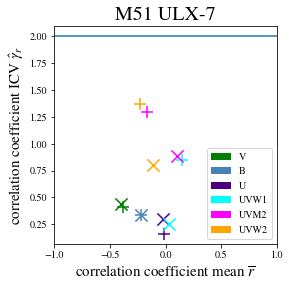

SMC_X-3
SMC X-3                                 U                             0.6379	0.0321	19.853010000
SMC X-3                                 U                             0.4351	0.0369	11.783410000
SMC X-3                                 UVW1                          -0.8066	0.0582	13.861210000
SMC X-3                                 UVW1                          -0.5619	0.0413	13.591110000
SMC X-3                                 UVM2                          0.7139	0.0896	7.969510000
SMC X-3                                 UVM2                          0.0494	0.0582	0.849510000


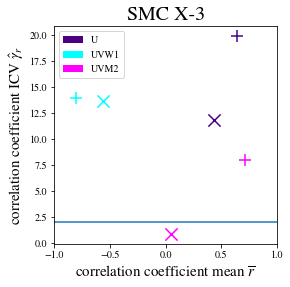

SS433
SS433                                   V                             0.2801	0.0281	9.982510000
SS433                                   V                             0.2807	0.0277	10.122810000
SS433                                   B                             0.2318	0.0448	5.169910000
SS433                                   B                             0.2326	0.0440	5.291810000
SS433                                   U                             0.2083	0.0390	5.347010000
SS433                                   U                             0.2085	0.0383	5.443210000
SS433                                   UVW1                          0.1618	0.1186	1.364510000
SS433                                   UVW1                          0.2294	0.1125	2.038510000
SS433                                   UVW2                          0.2810	0.1763	1.594010000
SS433                                   UVW2                          0.2840	0.1777	1.598110000


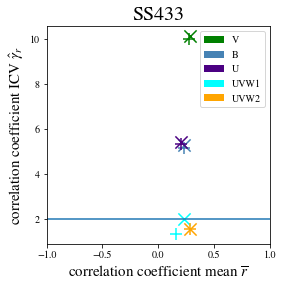

SWIFT_J0243.6+6124
Swift J0243.6+6124                      V                             0.8203	0.0257	31.968210000
Swift J0243.6+6124                      V                             0.7850	0.0278	28.262910000
Swift J0243.6+6124                      B                             0.7528	0.0246	30.544510000
Swift J0243.6+6124                      B                             0.7458	0.0248	30.124910000
Swift J0243.6+6124                      U                             0.7127	0.0130	54.816210000
Swift J0243.6+6124                      U                             0.6765	0.0091	74.199710000
Swift J0243.6+6124                      UVW1                          0.9117	0.0243	37.471810000
Swift J0243.6+6124                      UVW1                          0.8656	0.0232	37.238610000
Swift J0243.6+6124                      UVM2                          0.6359	0.0682	9.325110000
Swift J0243.6+6124                      UVM2                          0.6379	0.0655	9.732010000
Swift J0243.6

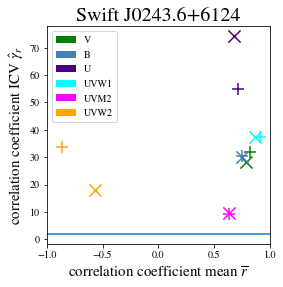

[LB2005]_NGC_253_X2
NGC253 X-2                              U                             0.0809	0.2429	0.332910000
NGC253 X-2                              U                             0.0056	0.2745	0.020310000


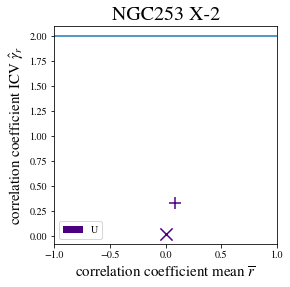

[LB2005]_NGC_253_X9
NGC253 X-9                              U                             0.7161	0.2123	3.373610000
NGC253 X-9                              U                             0.0095	0.2997	0.031710000


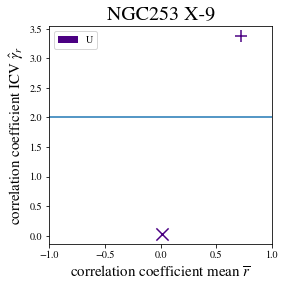

[LB2005]_NGC_5236_X11
M83 ULX-2                               U                             -0.1930	0.0910	2.121310000
M83 ULX-2                               U                             -0.1511	0.0788	1.917210000
M83 ULX-2                               UVW1                          -0.1119	0.1791	0.624710000
M83 ULX-2                               UVW1                          -0.1038	0.1762	0.589110000
M83 ULX-2                               UVM2                          -0.1693	0.1491	1.135010000
M83 ULX-2                               UVM2                          -0.1251	0.1383	0.904710000


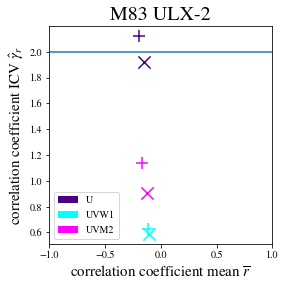

[LB2005]_NGC_6946_ULX1
NGC6946 ULX-1                           V                             0.0014	0.1037	0.013010000
NGC6946 ULX-1                           B                             0.0091	0.0841	0.107810000
NGC6946 ULX-1                           U                             0.0592	0.0934	0.633010000
NGC6946 ULX-1                           UVW1                          0.0090	0.0934	0.095910000
NGC6946 ULX-1                           UVM2                          -0.0538	0.1287	0.418010000
NGC6946 ULX-1                           UVW2                          -0.0069	0.0627	0.109410000


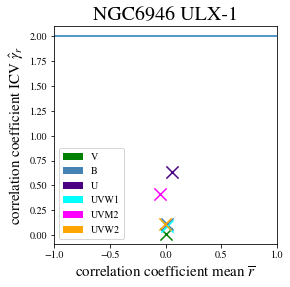

[LB2005]_NGC_6946_ULX3
NGC6946 ULX-3                           V                             -0.0023	0.0921	0.024710000
NGC6946 ULX-3                           V                             0.0019	0.0923	0.021010000
NGC6946 ULX-3                           B                             -0.0063	0.0905	0.069210000
NGC6946 ULX-3                           B                             -0.0375	0.0870	0.430610000
NGC6946 ULX-3                           U                             -0.0309	0.0954	0.323410000
NGC6946 ULX-3                           U                             -0.0262	0.0916	0.285910000
NGC6946 ULX-3                           UVW1                          0.0004	0.1020	0.003610000
NGC6946 ULX-3                           UVW1                          -0.0018	0.1004	0.017710000
NGC6946 ULX-3                           UVM2                          0.0225	0.1642	0.137210000
NGC6946 ULX-3                           UVM2                          -0.0064	0.1593	0.040310000
NGC6946 UL

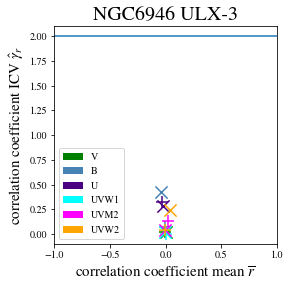

[LM2005]_NGC_247_ULX1
NGC247 ULX-1                            U                             -0.1520	0.1459	1.041710000
NGC247 ULX-1                            U                             -0.0607	0.1335	0.454910000
NGC247 ULX-1                            UVW1                          -0.1106	0.1388	0.796910000
NGC247 ULX-1                            UVW1                          -0.1089	0.1135	0.959410000
NGC247 ULX-1                            UVM2                          0.1229	0.1192	1.031110000
NGC247 ULX-1                            UVM2                          0.0323	0.0962	0.335710000
NGC247 ULX-1                            UVW2                          -0.3319	0.1722	1.928010000
NGC247 ULX-1                            UVW2                          -0.1306	0.2345	0.557010000


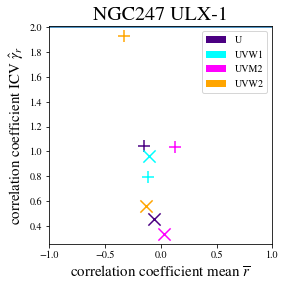

[LM2005]_NGC_3031_ULX1
M81 X-6                                 V                             -0.0462	0.0985	0.468910000
M81 X-6                                 V                             -0.0453	0.0977	0.463510000
M81 X-6                                 B                             0.0109	0.0966	0.113110000
M81 X-6                                 B                             0.0116	0.0981	0.118110000
M81 X-6                                 U                             -0.0524	0.1102	0.475710000
M81 X-6                                 U                             -0.0524	0.1115	0.469410000
M81 X-6                                 UVW1                          -0.0630	0.0657	0.958710000
M81 X-6                                 UVW1                          -0.0778	0.0725	1.073010000
M81 X-6                                 UVM2                          0.2439	0.1223	1.993810000
M81 X-6                                 UVM2                          0.2449	0.1218	2.011510000
M81 X-6    

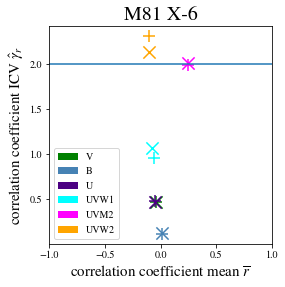

[LM2005]_NGC_4395_ULX1
NGC4395 ULX-1                           V                             0.0316	0.1074	0.294010000
NGC4395 ULX-1                           V                             0.0101	0.0911	0.110510000
NGC4395 ULX-1                           B                             -0.0143	0.1003	0.143010000
NGC4395 ULX-1                           B                             -0.0199	0.0812	0.245410000
NGC4395 ULX-1                           U                             -0.2199	0.3733	0.589210000
NGC4395 ULX-1                           U                             -0.1271	0.2558	0.496610000
NGC4395 ULX-1                           UVW1                          0.4198	0.2872	1.462010000
NGC4395 ULX-1                           UVW1                          0.4360	0.2072	2.104110000
NGC4395 ULX-1                           UVM2                          0.1682	0.3965	0.424310000
NGC4395 ULX-1                           UVM2                          -0.0193	0.1425	0.135510000
NGC4395 ULX-

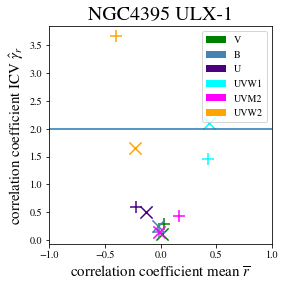

[LM2005]_NGC_4559_ULX1
NGC4559 ULX-1                           B                             -0.0148	0.9999	0.014810000
NGC4559 ULX-1                           B                             -0.0044	1.0000	0.004410000
NGC4559 ULX-1                           U                             0.4409	0.2018	2.184810000
NGC4559 ULX-1                           U                             0.3514	0.2200	1.597510000
NGC4559 ULX-1                           UVW1                          0.0645	0.1072	0.601210000
NGC4559 ULX-1                           UVW1                          0.0665	0.1057	0.629310000
NGC4559 ULX-1                           UVM2                          -0.3420	0.1377	2.483110000
NGC4559 ULX-1                           UVM2                          0.1379	0.1043	1.321310000
NGC4559 ULX-1                           UVW2                          0.1686	0.1160	1.453310000
NGC4559 ULX-1                           UVW2                          0.1083	0.1138	0.951910000


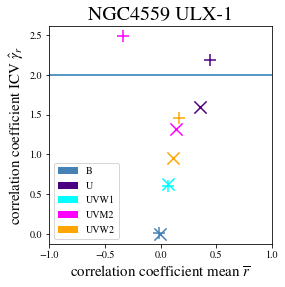

[LM2005]_NGC_5204_ULX1
NGC5204 ULX-1                           U                             -0.1972	0.1139	1.732010000
NGC5204 ULX-1                           U                             -0.1968	0.1131	1.740110000
NGC5204 ULX-1                           UVW1                          -0.1803	0.2621	0.687710000
NGC5204 ULX-1                           UVW1                          -0.1785	0.2611	0.683510000
NGC5204 ULX-1                           UVM2                          0.0266	0.2359	0.113010000
NGC5204 ULX-1                           UVM2                          -0.0278	0.2326	0.119410000
NGC5204 ULX-1                           UVW2                          -0.0892	0.2366	0.377110000
NGC5204 ULX-1                           UVW2                          -0.0877	0.2403	0.365010000


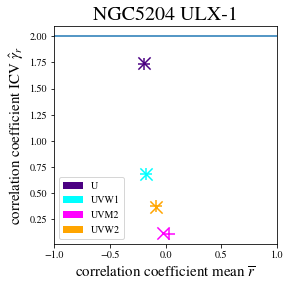

[LM2005]_NGC_5408_ULX1
NGC5408 ULX-1                           UVM2                          -0.1293	0.0617	2.096310000
NGC5408 ULX-1                           UVM2                          -0.1563	0.0643	2.431710000


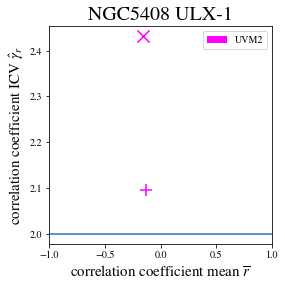

[SRW2006b]_NGC_55_ULX
NGC55 ULX                               U                             -0.1168	0.0524	2.228910000
NGC55 ULX                               U                             -0.1174	0.0522	2.250110000
NGC55 ULX                               UVW1                          -0.0231	0.0870	0.265710000
NGC55 ULX                               UVW1                          -0.0193	0.0866	0.223410000
NGC55 ULX                               UVM2                          0.2356	0.2355	1.000610000
NGC55 ULX                               UVM2                          0.2344	0.2329	1.006410000
NGC55 ULX                               UVW2                          -0.2499	0.1263	1.979110000
NGC55 ULX                               UVW2                          -0.2501	0.1270	1.969110000


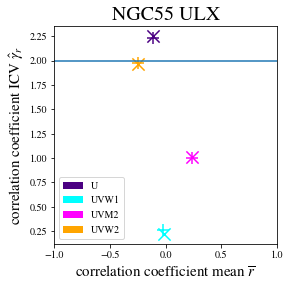

[SST2011]_J141939.39+564137.8
NGC5585 ULX                             UVM2                          0.0490	0.9988	0.049110000
NGC5585 ULX                             UVM2                          -0.0232	0.2300	0.100910000


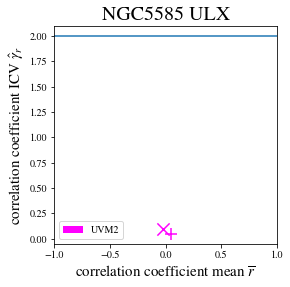

In [11]:
for simbad_name in df_fit_samples['simbad_name'].unique():
    filters_to_plot = []
    print(simbad_name)
    readable_name  = source_names_readable[simbad_name]
    fig, ax = plt.subplots(1,1,figsize=(4,4), facecolor='white')    
    
    ax.set_title(f'{readable_name}', size=20)
    ax.set_xlabel(r'correlation coefficient mean $\overline{r}$', size=15)
    ax.set_ylabel(r'correlation coefficient ICV $\hat{\gamma}_{r}$', size=15)
    ax.set_xlim(-1,1)
    
    sub1 = df_fit_samples[df_fit_samples['simbad_name'] == simbad_name]
    
    
    
    for uvot_filter in ['V','B','U','UVW1','UVM2','UVW2','WHITE']:
        sub2 = sub1[sub1['uvot_filter'] == uvot_filter]
        for xrt_band in ['HARD']:
            sub3   = sub2[sub2['xrt_curve'] == xrt_band]
            sub_FF = sub3[(sub3['include_bad'] == 'False') & (sub3['include_UL'] == 'False')]
            sub_TF = sub3[(sub3['include_bad'] == 'True') & (sub3['include_UL'] == 'False')]

            
            
            title = ['bad=false', 'bad=true']

            markers = {'FULL_FF': '+',
                       'SOFT_FF': r'$\mathrm{S}$',
                       'HARD_FF': '+',
                       'FULL_TF': r'$\mathrm{\overline{F}}$',
                       'SOFT_TF': r'$\mathrm{\overline{S}}$',
                       'HARD_TF': 'x'}

            pars = ['FF','TF']
            
            
            for i, df in enumerate([sub_FF, sub_TF]):
                marker = markers[f'{xrt_band}_{pars[i]}']
                r        = df['r'].mean()
                r_std    = df['r'].std()
                r_nsig   = abs(r / r_std)

                #if (r_nsig < 2) or np.isnan(r_nsig):
                #    continue
                #else:
                if np.isnan(r_nsig):
                    continue
                else:    
                    ax.scatter(r, r_nsig, marker=marker, color=filter_colors[uvot_filter], s=150)
                    print(f'{readable_name:<40}{uvot_filter:<30}{r:.4f}\t{r_std:.4f}\t{r_nsig:.4f}{len(sub_TF)}')
                    filters_to_plot.append(uvot_filter)
                    

    #ax.set_yscale('log')
    #ax.set_yticks([2,5,10,25,50], labels=[2,5,10,25,50])


    #names_to_plot = list(dict.fromkeys(names_to_plot))
    #legend_elements = [Patch(facecolor=source_name_colors[simbad_name], label=source_names_readable[simbad_name]) for simbad_name in names_to_plot]


    filters_to_plot = list(set(filters_to_plot))
    filters_to_plot = sorted(filters_to_plot,key=['V','B','U','UVW1','UVM2','UVW2','WHITE'].index)
    legend_elements = [Patch(facecolor=filter_colors[f], label=f) for f in filters_to_plot]
    ax.legend(handles=legend_elements, ncol=1)
    
    ax.axhline(2)
    #ax.legend(ncol=1, loc='upper left')

    plt.savefig(f'../figures/r_vs_r_sig/source_plots/{readable_name}.pdf', bbox_inches='tight')
    plt.savefig(f'../figures/r_vs_r_sig/source_plots/{readable_name}.png', bbox_inches='tight')
    plt.show()

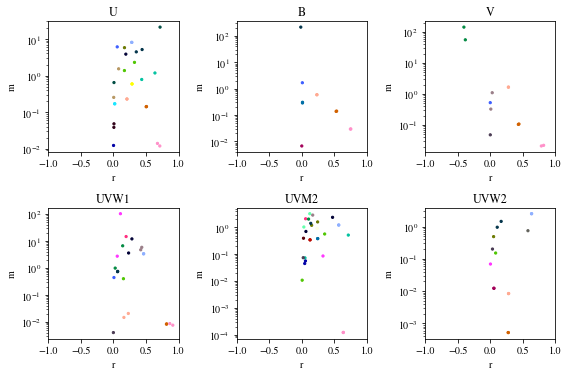

In [16]:
fig, ax = plt.subplots(2,3, figsize=(8, 2/3 * 8))

uvot_filters = ['U', 'B', 'V', 'UVW1', 'UVM2', 'UVW2']

for i, a in enumerate(ax.flatten()):
    a.set_xlim(-1,1)
    a.set_title(uvot_filters[i])
    
    sub = df_fit_val_idx.loc[:,'HARD',uvot_filters[i],:,:]
    sub.plot(kind='scatter', x='r_mean', y='m_mean', ax=a, marker='.', xlabel='r', ylabel='m', c=sub.reset_index()['simbad_name'].map(source_name_colors))
    
    #a.legend()
    a.set_yscale('log')
    
#sub = df_fit_val_idx.loc[:,'HARD','U',:,:]
#ax[0][0].errorbar(sub['r_mean'], sub['m_mean'], xerr=sub['r_std'], yerr=sub['m_std'], ls='none', capsize=1.0, lw=1.0)


plt.tight_layout()

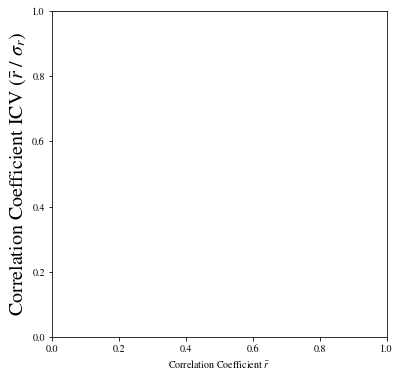

In [17]:
plt.figure(figsize=(6,6))
plt.xlabel(r'Correlation Coefficient $\bar{r}$')
plt.ylabel(r'Correlation Coefficient ICV ($\bar{r} \ / \ \sigma_{r}$)', fontsize=20)
plt.show()

In [18]:
df_fit_val

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,r_nsig
0,Holmberg_II_X-1,FULL,U,False,False,0.072601,0.043464,0.258043,0.154851,4.577567,0.025400,1.670361
1,Holmberg_II_X-1,FULL,U,False,True,0.242112,0.049480,1.456759,0.540213,4.341777,0.104518,4.893109
2,Holmberg_II_X-1,FULL,U,True,False,0.072735,0.043045,0.258674,0.153300,4.577288,0.025294,1.689768
3,Holmberg_II_X-1,FULL,U,True,True,0.242648,0.048880,1.469303,0.536720,4.339227,0.103948,4.964126
4,Holmberg_II_X-1,FULL,UVM2,False,False,0.059412,0.091786,0.186595,0.294732,1.968741,0.059692,0.647294
...,...,...,...,...,...,...,...,...,...,...,...,...
1154,[SST2011]_J141939.39+564137.8,FULL,UVM2,True,True,0.140920,0.217337,1.002041,1.604567,0.099283,0.016460,0.648394
1155,[SST2011]_J141939.39+564137.8,HARD,UVM2,False,False,0.049000,0.998849,-60.289984,4706.524465,0.766172,53.683322,0.049056
1156,[SST2011]_J141939.39+564137.8,HARD,UVM2,True,False,-0.023205,0.230020,-0.125867,1.461549,0.120324,0.008668,0.100885
1157,[SST2011]_J141939.39+564137.8,SOFT,UVM2,False,False,-0.034800,0.999444,-3.303507,265.504283,0.128762,1.327085,0.034819


In [19]:
df_fit_val_idx.loc[:,'HARD','U',:,:]

r_mean     r_std     m_mean  \
simbad_name            include_bad include_UL                                  
Holmberg_II_X-1        False       False       0.020546  0.050091   0.168511   
                       True        False       0.020625  0.049158   0.169226   
M82_X-2                False       False      -0.165343  0.055409  -0.282861   
                       True        False      -0.165124  0.055588  -0.282476   
NAME_Holmberg_IX_X-1   False       False       0.286090  0.061883   0.587713   
                       True        False       0.286494  0.061537   0.589108   
NAME_IC_10_X-1         False       False       0.009292  0.073125   0.047912   
                       True        False       0.008040  0.067367   0.038418   
NAME_M83_ULX-1         False       False       0.191507  0.075326   3.839756   
                       True        False      -0.176440  0.048108 -10.611400   
NAME_NGC_1313_X-1      False       False      -0.129633  0.025128  -0.781042   
                       True        False      -0.127931  0.026284  -0.773378   
NAME_NGC_1313_X-2      False       False      -0.026097  0.039167  -0.099701   
                       True        False       0.002923  0.037473   0.012287   
NAME_NGC_1365-X1       True        False      -0.036801  0.181681 -10.565137   
NAME_NGC_300_ULX1      False       False       0.282414  0.041786   8.043080   
                       True        False       0.281958  0.041596   8.038923   
NAME_NGC_5907_ULX      False       False       0.324046  0.193594   2.286080   
                       True        False       0.169689  0.068079   1.367712   
NAME_NGC_7090_ULX3     True        False      -0.344030  0.247784 -48.981913   
NAME_NGC_7793_P13      False       False      -0.174369  0.046829  -0.718799   
                       True        False      -0.043657  0.039910  -0.179704   
NAME_NGC_925_ULX-1     False       False      -0.150323  0.194094  -0.489432   
                       True        False      -0.150530  0.192270  -0.493900   
NAME_NGC_925_ULX-2     False       False       0.170534  0.334240   5.769053   
                       True        False      -0.070385  0.175623  -0.641887   
NOVA_Cyg_1989          False       False       0.502979  0.013017   0.139979   
                       True        False       0.508297  0.012722   0.142193   
RX_J133001+47137       False       False      -0.018822  0.116421  -0.865258   
                       True        False      -0.020600  0.068834  -1.172703   
SMC_X-3                False       False       0.637862  0.032129   1.173461   
                       True        False       0.435063  0.036922   0.779540   
SS433                  False       False       0.208320  0.038960   0.227923   
                       True        False       0.208468  0.038299   0.228252   
SWIFT_J0243.6+6124     False       False       0.712684  0.013001   0.011886   
                       True        False       0.676455  0.009117   0.013960   
[LB2005]_NGC_253_X2    False       False       0.080880  0.242924   1.524326   
                       True        False       0.005573  0.274498   0.252775   
[LB2005]_NGC_253_X9    False       False       0.716142  0.212278  21.019946   
                       True        False       0.009495  0.299662   0.641986   
[LB2005]_NGC_5236_X11  False       False      -0.192981  0.090974 -19.446390   
                       True        False      -0.151066  0.078795 -17.419179   
[LB2005]_NGC_6946_ULX1 True        False       0.059152  0.093443   6.062061   
[LB2005]_NGC_6946_ULX3 False       False      -0.030854  0.095414  -0.713370   
                       True        False      -0.026194  0.091611  -0.606211   
[LM2005]_NGC_247_ULX1  False       False      -0.151982  0.145896  -3.531750   
                       True        False      -0.060742  0.133539  -1.590907   
[LM2005]_NGC_3031_ULX1 False       False      -0.052407  0.110163  -0.572061   
                       True        False      -0.